In [1]:

import os
import time
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import logging
import joblib
import gc  # For garbage collection

# Import from our refactored modules
from common import (
    # Logger
    logger, setup_logger,
    
    # Data loading
    load_eeg_data,

    # Data quality analysis
    analyze_data_quality,
    
    # Preprocessing
    preprocess_eeg_data, engineer_eeg_features,
    
    # Disk-based bundle functions
    create_coherent_time_series_bundles_disk, normalize_bundles_disk,
    
    # Models
    UnsupervisedModelTrainer,
    
    # Visualization
    visualize_eeg_data
)

def print_section_header(title):
    """Print a section header to make output easier to read"""
    logger.info("\n" + "="*80)
    logger.info(f" {title}")
    logger.info("="*80)

def setup_directories(base_dir):
    """Create output directories if they don't exist"""
    os.makedirs(base_dir, exist_ok=True)
    
    # Create subdirectories
    models_dir = os.path.join(base_dir, "models")
    os.makedirs(models_dir, exist_ok=True)
    
    plots_dir = os.path.join(base_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    bundle_dir = os.path.join(base_dir, "bundles")
    os.makedirs(bundle_dir, exist_ok=True)
    
    return {
        "base": base_dir,
        "models": models_dir,
        "plots": plots_dir,
        "bundles": bundle_dir
    }

def save_plot(fig, filename, output_dir):
    """Save matplotlib figure to file"""
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close(fig)
    logger.info(f"Saved plot: {filepath}")

def load_bundle_info(bundle_dir):
    """
    Load bundle information from a directory
    
    Parameters:
        bundle_dir (str): Path to the directory containing bundle information
        
    Returns:
        dict: Bundle information dictionary
    """
    # Check for bundle info file
    info_path = os.path.join(bundle_dir, "bundle_info.joblib")
    
    if not os.path.exists(info_path):
        raise FileNotFoundError(f"Bundle info file not found in {bundle_dir}")
    
    # Load bundle info
    bundle_info = joblib.load(info_path)
    
    # Validate the bundle info
    required_keys = ['total_bundles', 'bundle_size', 'feature_dim', 'output_dir']
    for key in required_keys:
        if key not in bundle_info:
            raise ValueError(f"Bundle info is missing required key: {key}")
    
    # Make sure paths are correct if the bundles were moved
    if os.path.abspath(bundle_info['output_dir']) != os.path.abspath(bundle_dir):
        logger.warning(f"Bundle directory has changed from {bundle_info['output_dir']} to {bundle_dir}")
        bundle_info['output_dir'] = os.path.abspath(bundle_dir)
    
    return bundle_info


In [2]:
output_dir = "./eeg_bundles"
log_level = "INFO"
data_dir = "../data"
load_existing = True
n_clusters = 2
bundle_size = 30
step_size = 30

# Configure logging
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = os.path.join(output_dir, "logs")
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"pipeline_{timestamp}.log")

# Convert string log level to actual level
numeric_level = getattr(logging, log_level.upper(), None)
setup_logger(name="eeg_classification", level=numeric_level, log_file=log_file)

# Start timer
start_time = time.time()

logger.info("Starting EEG Processing Pipeline")
logger.info(f"Data directory: {data_dir}")
logger.info(f"Output directory: {output_dir}")
logger.info(f"Log file: {log_file}")

# Setup directories
dirs = setup_directories(output_dir)

# Set bundle directory
bundle_dir = dirs["bundles"]



2025-03-14 09:27:45,467 - eeg_classification - INFO - Starting EEG Processing Pipeline
2025-03-14 09:27:45,467 - eeg_classification - INFO - Starting EEG Processing Pipeline


2025-03-14 09:27:45,467 - eeg_classification - INFO - Starting EEG Processing Pipeline


2025-03-14 09:27:45,471 - eeg_classification - INFO - Data directory: ../data
2025-03-14 09:27:45,471 - eeg_classification - INFO - Data directory: ../data


2025-03-14 09:27:45,471 - eeg_classification - INFO - Data directory: ../data


2025-03-14 09:27:45,473 - eeg_classification - INFO - Output directory: ./eeg_bundles
2025-03-14 09:27:45,473 - eeg_classification - INFO - Output directory: ./eeg_bundles


2025-03-14 09:27:45,473 - eeg_classification - INFO - Output directory: ./eeg_bundles


2025-03-14 09:27:45,475 - eeg_classification - INFO - Log file: ./eeg_bundles\logs\pipeline_20250314_092745.log
2025-03-14 09:27:45,475 - eeg_classification - INFO - Log file: ./eeg_bundles\logs\pipeline_20250314_092745.log


2025-03-14 09:27:45,475 - eeg_classification - INFO - Log file: ./eeg_bundles\logs\pipeline_20250314_092745.log


2025-03-14 09:27:45,506 - eeg_classification - INFO - Checking for existing bundles...
2025-03-14 09:27:45,506 - eeg_classification - INFO - Checking for existing bundles...


2025-03-14 09:27:45,506 - eeg_classification - INFO - Checking for existing bundles...


2025-03-14 09:27:45,509 - eeg_classification - WARNING - Could not load existing bundles: Bundle info file not found in ./eeg_bundles\bundles
2025-03-14 09:27:45,509 - eeg_classification - WARNING - Could not load existing bundles: Bundle info file not found in ./eeg_bundles\bundles


2025-03-14 09:27:45,509 - eeg_classification - WARNING - Could not load existing bundles: Bundle info file not found in ./eeg_bundles\bundles


2025-03-14 09:27:45,514 - eeg_classification - INFO - 
2025-03-14 09:27:45,514 - eeg_classification - INFO - 


2025-03-14 09:27:45,514 - eeg_classification - INFO - 


2025-03-14 09:27:45,516 - eeg_classification - INFO -  Step 1: Loading EEG data
2025-03-14 09:27:45,516 - eeg_classification - INFO -  Step 1: Loading EEG data


2025-03-14 09:27:45,516 - eeg_classification - INFO -  Step 1: Loading EEG data


2025-03-14 09:27:45,518 - eeg_classification - INFO - ================================================================================
2025-03-14 09:27:45,518 - eeg_classification - INFO - ================================================================================


2025-03-14 09:27:45,518 - eeg_classification - INFO - ================================================================================


2025-03-14 09:27:45,520 - eeg_classification - INFO - Loading data from ../data
2025-03-14 09:27:45,520 - eeg_classification - INFO - Loading data from ../data


2025-03-14 09:27:45,520 - eeg_classification - INFO - Loading data from ../data


2025-03-14 09:28:24,886 - eeg_classification - INFO - Loaded 30 files with 6947837 total rows
2025-03-14 09:28:24,886 - eeg_classification - INFO - Loaded 30 files with 6947837 total rows


2025-03-14 09:28:24,886 - eeg_classification - INFO - Loaded 30 files with 6947837 total rows


2025-03-14 09:28:24,889 - eeg_classification - INFO - Loaded 30 files with 6947837 total rows
2025-03-14 09:28:24,889 - eeg_classification - INFO - Loaded 30 files with 6947837 total rows


2025-03-14 09:28:24,889 - eeg_classification - INFO - Loaded 30 files with 6947837 total rows


2025-03-14 09:28:24,891 - eeg_classification - INFO - Sample file file_1 shape: (108335, 42)
2025-03-14 09:28:24,891 - eeg_classification - INFO - Sample file file_1 shape: (108335, 42)


2025-03-14 09:28:24,891 - eeg_classification - INFO - Sample file file_1 shape: (108335, 42)


2025-03-14 09:28:24,901 - eeg_classification - WARNING - Too many columns (39). Showing only the first 5.
2025-03-14 09:28:24,901 - eeg_classification - WARNING - Too many columns (39). Showing only the first 5.


2025-03-14 09:28:24,901 - eeg_classification - WARNING - Too many columns (39). Showing only the first 5.


2025-03-14 09:28:24,963 - eeg_classification - ERROR - Error loading data: time data "2024-06-02 09:47:18" doesn't match format "%Y-%m-%d %H:%M:%S.%f", at position 156. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
2025-03-14 09:28:24,963 - eeg_classification - ERROR - Error loading data: time data "2024-06-02 09:47:18" doesn't match format "%Y-%m-%d %H:%M:%S.%f", at position 156. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use

2025-03-14 09:28:24,963 - eeg_classification - ERROR - Error loading data: time data "2024-06-02 09:47:18" doesn't match format "%Y-%m-%d %H:%M:%S.%f", at position 156. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


2025-03-14 09:28:24,966 - eeg_classification - ERROR - Stack trace:
Traceback (most recent call last):
  File "C:\Users\Huai\AppData\Local\Temp\ipykernel_32816\609321440.py", line 35, in <module>
    fig = visualize_eeg_data(sample_df, max_cols=5)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\visualization.py", line 51, in visualize_eeg_data
    x = pd.to_datetime(df['TimeStamp'])
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\miniconda3\envs\eeg\Lib\site-packages\pandas\core\tools\datetimes.py", line 1063, in to_datetime
    cache_array = _maybe_cache(arg, format, cache, convert_listlike)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\miniconda3\envs\eeg\Lib\site-packages\pandas\core\tools\datetimes.py", line 247, in _maybe_cache
    cache_dates = convert_listlike(unique_dates, format)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

2025-03-14 09:28:24,966 - eeg_classification - ERROR - Stack trace:
Traceback (most recent call last):
  File "C:\Users\Huai\AppData\Local\Temp\ipykernel_32816\609321440.py", line 35, in <module>
    fig = visualize_eeg_data(sample_df, max_cols=5)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\visualization.py", line 51, in visualize_eeg_data
    x = pd.to_datetime(df['TimeStamp'])
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\miniconda3\envs\eeg\Lib\site-packages\pandas\core\tools\datetimes.py", line 1063, in to_datetime
    cache_array = _maybe_cache(arg, format, cache, convert_listlike)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\miniconda3\envs\eeg\Lib\site-packages\pandas\core\tools\datetimes.py", line 247, in _maybe_cache
    cache_dates = convert_listlike(unique_dates, format)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

2025-03-14 09:28:24,971 - eeg_classification - INFO - Step 1 completed in 39.45 seconds
2025-03-14 09:28:24,971 - eeg_classification - INFO - Step 1 completed in 39.45 seconds


2025-03-14 09:28:24,971 - eeg_classification - INFO - Step 1 completed in 39.45 seconds


2025-03-14 09:28:24,973 - eeg_classification - INFO - 
2025-03-14 09:28:24,973 - eeg_classification - INFO - 


2025-03-14 09:28:24,973 - eeg_classification - INFO - 


2025-03-14 09:28:24,976 - eeg_classification - INFO -  Step 2: Processing data and engineering features
2025-03-14 09:28:24,976 - eeg_classification - INFO -  Step 2: Processing data and engineering features


2025-03-14 09:28:24,976 - eeg_classification - INFO -  Step 2: Processing data and engineering features


2025-03-14 09:28:24,977 - eeg_classification - INFO - ================================================================================
2025-03-14 09:28:24,977 - eeg_classification - INFO - ================================================================================


2025-03-14 09:28:24,977 - eeg_classification - INFO - ================================================================================


2025-03-14 09:28:24,979 - eeg_classification - INFO - Analyzing data quality for sample file file_1
2025-03-14 09:28:24,979 - eeg_classification - INFO - Analyzing data quality for sample file file_1


2025-03-14 09:28:24,979 - eeg_classification - INFO - Analyzing data quality for sample file file_1


2025-03-14 09:28:24,998 - eeg_classification - INFO - Data shape: 108335 rows × 42 columns
2025-03-14 09:28:24,998 - eeg_classification - INFO - Data shape: 108335 rows × 42 columns


2025-03-14 09:28:24,998 - eeg_classification - INFO - Data shape: 108335 rows × 42 columns


2025-03-14 09:28:25,000 - eeg_classification - INFO - Total missing values: 116505 (2.56%)
2025-03-14 09:28:25,000 - eeg_classification - INFO - Total missing values: 116505 (2.56%)


2025-03-14 09:28:25,000 - eeg_classification - INFO - Total missing values: 116505 (2.56%)


2025-03-14 09:28:25,019 - eeg_classification - WARNING - Found 1 columns with >50.0% NaN values:
2025-03-14 09:28:25,019 - eeg_classification - WARNING - Found 1 columns with >50.0% NaN values:


2025-03-14 09:28:25,019 - eeg_classification - WARNING - Found 1 columns with >50.0% NaN values:


2025-03-14 09:28:25,022 - eeg_classification - WARNING -   - Elements: 99.8% NaNs (108120 values)
2025-03-14 09:28:25,022 - eeg_classification - WARNING -   - Elements: 99.8% NaNs (108120 values)


2025-03-14 09:28:25,022 - eeg_classification - WARNING -   - Elements: 99.8% NaNs (108120 values)


2025-03-14 09:28:25,025 - eeg_classification - INFO - Found 2 columns with no NaN values
2025-03-14 09:28:25,025 - eeg_classification - INFO - Found 2 columns with no NaN values


2025-03-14 09:28:25,025 - eeg_classification - INFO - Found 2 columns with no NaN values


2025-03-14 09:28:25,177 - eeg_classification - INFO - Recommendations based on data quality analysis:
2025-03-14 09:28:25,177 - eeg_classification - INFO - Recommendations based on data quality analysis:


2025-03-14 09:28:25,177 - eeg_classification - INFO - Recommendations based on data quality analysis:


2025-03-14 09:28:25,179 - eeg_classification - INFO - 1. Consider dropping columns with high NaN percentages: Elements
2025-03-14 09:28:25,179 - eeg_classification - INFO - 1. Consider dropping columns with high NaN percentages: Elements


2025-03-14 09:28:25,179 - eeg_classification - INFO - 1. Consider dropping columns with high NaN percentages: Elements


2025-03-14 09:28:25,846 - eeg_classification - INFO - Saved plot: ./eeg_bundles\plots\sample_data_quality.png
2025-03-14 09:28:25,846 - eeg_classification - INFO - Saved plot: ./eeg_bundles\plots\sample_data_quality.png


2025-03-14 09:28:25,846 - eeg_classification - INFO - Saved plot: ./eeg_bundles\plots\sample_data_quality.png


2025-03-14 09:28:25,849 - eeg_classification - INFO - Saved list of ['Elements'] high-NaN columns for reference
2025-03-14 09:28:25,849 - eeg_classification - INFO - Saved list of ['Elements'] high-NaN columns for reference


2025-03-14 09:28:25,849 - eeg_classification - INFO - Saved list of ['Elements'] high-NaN columns for reference


2025-03-14 09:28:25,851 - eeg_classification - INFO - Processing file file_1 with 108335 rows
2025-03-14 09:28:25,851 - eeg_classification - INFO - Processing file file_1 with 108335 rows


2025-03-14 09:28:25,851 - eeg_classification - INFO - Processing file file_1 with 108335 rows


2025-03-14 09:28:25,874 - eeg_classification - WARNING - Input data for file file_1 contains 8385 NaN values
2025-03-14 09:28:25,874 - eeg_classification - WARNING - Input data for file file_1 contains 8385 NaN values


2025-03-14 09:28:25,874 - eeg_classification - WARNING - Input data for file file_1 contains 8385 NaN values


2025-03-14 09:28:25,876 - eeg_classification - INFO - Preprocessing data with shape (108335, 41)
2025-03-14 09:28:25,876 - eeg_classification - INFO - Preprocessing data with shape (108335, 41)


2025-03-14 09:28:25,876 - eeg_classification - INFO - Preprocessing data with shape (108335, 41)


2025-03-14 09:28:25,943 - eeg_classification - WARNING - Dropping 215 rows with invalid timestamps
2025-03-14 09:28:25,943 - eeg_classification - WARNING - Dropping 215 rows with invalid timestamps


2025-03-14 09:28:25,943 - eeg_classification - WARNING - Dropping 215 rows with invalid timestamps


2025-03-14 09:28:25,958 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 108120
2025-03-14 09:28:25,958 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 108120


2025-03-14 09:28:25,958 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 108120


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:26,019 - eeg_classification - INFO - Data spans 422.21 seconds from 2024-06-02 09:47

2025-03-14 09:28:26,019 - eeg_classification - INFO - Data spans 422.21 seconds from 2024-06-02 09:47:17.286000 to 2024-06-02 09:54:19.497000


2025-03-14 09:28:26,125 - eeg_classification - INFO - Sampling complete: 108120 -> 4250 data points (3.9%)
2025-03-14 09:28:26,125 - eeg_classification - INFO - Sampling complete: 108120 -> 4250 data points (3.9%)


2025-03-14 09:28:26,125 - eeg_classification - INFO - Sampling complete: 108120 -> 4250 data points (3.9%)


2025-03-14 09:28:26,134 - eeg_classification - INFO - Preprocessing complete. Output shape: (4250, 41)
2025-03-14 09:28:26,134 - eeg_classification - INFO - Preprocessing complete. Output shape: (4250, 41)


2025-03-14 09:28:26,134 - eeg_classification - INFO - Preprocessing complete. Output shape: (4250, 41)


2025-03-14 09:28:26,136 - eeg_classification - INFO - Cleaned data shape: (4250, 41)
2025-03-14 09:28:26,136 - eeg_classification - INFO - Cleaned data shape: (4250, 41)


2025-03-14 09:28:26,136 - eeg_classification - INFO - Cleaned data shape: (4250, 41)


2025-03-14 09:28:26,138 - eeg_classification - INFO - Engineering features from data with shape (4250, 41)
2025-03-14 09:28:26,138 - eeg_classification - INFO - Engineering features from data with shape (4250, 41)


2025-03-14 09:28:26,138 - eeg_classification - INFO - Engineering features from data with shape (4250, 41)
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()


2025-03-14 09:28:26,336 - eeg_classification - INFO - Feature engineering complete. Output shape: (4250, 140)
2025-03-14 09:28:26,336 - eeg_classification - INFO - Feature engineering complete. Output shape: (4250, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:26,336 - eeg_classification - INFO - Feature engineering complete. Output shape: (4250, 140)


2025-03-14 09:28:26,338 - eeg_classification - INFO - Features shape: (4250, 140)
2025-03-14 09:28:26,338 - eeg_classification - INFO - Features shape: (4250, 140)


2025-03-14 09:28:26,338 - eeg_classification - INFO - Features shape: (4250, 140)


2025-03-14 09:28:26,345 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:26,345 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:26,345 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:26,348 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:26,348 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:26,348 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:26,355 - eeg_classification - WARNING - Too many columns (138). Showing only the first 5.
2025-03-14 09:28:26,355 - eeg_classification - WARNING - Too many columns (138). Showing only the first 5.


2025-03-14 09:28:26,355 - eeg_classification - WARNING - Too many columns (138). Showing only the first 5.


2025-03-14 09:28:27,367 - eeg_classification - INFO - Saved plot: ./eeg_bundles\plots\processed_eeg_data.png
2025-03-14 09:28:27,367 - eeg_classification - INFO - Saved plot: ./eeg_bundles\plots\processed_eeg_data.png


2025-03-14 09:28:27,367 - eeg_classification - INFO - Saved plot: ./eeg_bundles\plots\processed_eeg_data.png


2025-03-14 09:28:27,517 - eeg_classification - INFO - Processing file file_2 with 75708 rows
2025-03-14 09:28:27,517 - eeg_classification - INFO - Processing file file_2 with 75708 rows


2025-03-14 09:28:27,517 - eeg_classification - INFO - Processing file file_2 with 75708 rows


2025-03-14 09:28:27,536 - eeg_classification - WARNING - Input data for file file_2 contains 3048 NaN values
2025-03-14 09:28:27,536 - eeg_classification - WARNING - Input data for file file_2 contains 3048 NaN values


2025-03-14 09:28:27,536 - eeg_classification - WARNING - Input data for file file_2 contains 3048 NaN values


2025-03-14 09:28:27,538 - eeg_classification - INFO - Preprocessing data with shape (75708, 41)
2025-03-14 09:28:27,538 - eeg_classification - INFO - Preprocessing data with shape (75708, 41)


2025-03-14 09:28:27,538 - eeg_classification - INFO - Preprocessing data with shape (75708, 41)


2025-03-14 09:28:27,586 - eeg_classification - WARNING - Dropping 48 rows with invalid timestamps
2025-03-14 09:28:27,586 - eeg_classification - WARNING - Dropping 48 rows with invalid timestamps


2025-03-14 09:28:27,586 - eeg_classification - WARNING - Dropping 48 rows with invalid timestamps


2025-03-14 09:28:27,599 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 75660
2025-03-14 09:28:27,599 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 75660


2025-03-14 09:28:27,599 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 75660


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:27,648 - eeg_classification - INFO - Data spans 295.30 seconds from 2024-06-03 05:38

2025-03-14 09:28:27,648 - eeg_classification - INFO - Data spans 295.30 seconds from 2024-06-03 05:38:00.925000 to 2024-06-03 05:42:56.225000


2025-03-14 09:28:27,710 - eeg_classification - INFO - Sampling complete: 75204 -> 3000 data points (4.0%)
2025-03-14 09:28:27,710 - eeg_classification - INFO - Sampling complete: 75204 -> 3000 data points (4.0%)


2025-03-14 09:28:27,710 - eeg_classification - INFO - Sampling complete: 75204 -> 3000 data points (4.0%)


2025-03-14 09:28:27,715 - eeg_classification - INFO - Preprocessing complete. Output shape: (3000, 41)
2025-03-14 09:28:27,715 - eeg_classification - INFO - Preprocessing complete. Output shape: (3000, 41)


2025-03-14 09:28:27,715 - eeg_classification - INFO - Preprocessing complete. Output shape: (3000, 41)


2025-03-14 09:28:27,717 - eeg_classification - INFO - Cleaned data shape: (3000, 41)
2025-03-14 09:28:27,717 - eeg_classification - INFO - Cleaned data shape: (3000, 41)


2025-03-14 09:28:27,717 - eeg_classification - INFO - Cleaned data shape: (3000, 41)


2025-03-14 09:28:27,719 - eeg_classification - INFO - Engineering features from data with shape (3000, 41)
2025-03-14 09:28:27,719 - eeg_classification - INFO - Engineering features from data with shape (3000, 41)


2025-03-14 09:28:27,719 - eeg_classification - INFO - Engineering features from data with shape (3000, 41)
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()


2025-03-14 09:28:27,865 - eeg_classification - INFO - Feature engineering complete. Output shape: (3000, 140)
2025-03-14 09:28:27,865 - eeg_classification - INFO - Feature engineering complete. Output shape: (3000, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:27,865 - eeg_classification - INFO - Feature engineering complete. Output shape: (3000, 140)


2025-03-14 09:28:27,867 - eeg_classification - INFO - Features shape: (3000, 140)
2025-03-14 09:28:27,867 - eeg_classification - INFO - Features shape: (3000, 140)


2025-03-14 09:28:27,867 - eeg_classification - INFO - Features shape: (3000, 140)


2025-03-14 09:28:27,874 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:27,874 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:27,874 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:27,877 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:27,877 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:27,877 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:28,015 - eeg_classification - INFO - Processing file file_3 with 129164 rows
2025-03-14 09:28:28,015 - eeg_classification - INFO - Processing file file_3 with 129164 rows


2025-03-14 09:28:28,015 - eeg_classification - INFO - Processing file file_3 with 129164 rows


2025-03-14 09:28:28,044 - eeg_classification - WARNING - Input data for file file_3 contains 4992 NaN values
2025-03-14 09:28:28,044 - eeg_classification - WARNING - Input data for file file_3 contains 4992 NaN values


2025-03-14 09:28:28,044 - eeg_classification - WARNING - Input data for file file_3 contains 4992 NaN values


2025-03-14 09:28:28,046 - eeg_classification - INFO - Preprocessing data with shape (129164, 41)
2025-03-14 09:28:28,046 - eeg_classification - INFO - Preprocessing data with shape (129164, 41)


2025-03-14 09:28:28,046 - eeg_classification - INFO - Preprocessing data with shape (129164, 41)


2025-03-14 09:28:28,125 - eeg_classification - WARNING - Dropping 128 rows with invalid timestamps
2025-03-14 09:28:28,125 - eeg_classification - WARNING - Dropping 128 rows with invalid timestamps


2025-03-14 09:28:28,125 - eeg_classification - WARNING - Dropping 128 rows with invalid timestamps


2025-03-14 09:28:28,144 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 129036
2025-03-14 09:28:28,144 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 129036


2025-03-14 09:28:28,144 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 129036


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:28,220 - eeg_classification - INFO - Data spans 503.95 seconds from 2024-06-05 17:23

2025-03-14 09:28:28,220 - eeg_classification - INFO - Data spans 503.95 seconds from 2024-06-05 17:23:37.961000 to 2024-06-05 17:32:01.910000


2025-03-14 09:28:28,351 - eeg_classification - INFO - Sampling complete: 129036 -> 5050 data points (3.9%)
2025-03-14 09:28:28,351 - eeg_classification - INFO - Sampling complete: 129036 -> 5050 data points (3.9%)


2025-03-14 09:28:28,351 - eeg_classification - INFO - Sampling complete: 129036 -> 5050 data points (3.9%)


2025-03-14 09:28:28,360 - eeg_classification - INFO - Preprocessing complete. Output shape: (5050, 41)
2025-03-14 09:28:28,360 - eeg_classification - INFO - Preprocessing complete. Output shape: (5050, 41)


2025-03-14 09:28:28,360 - eeg_classification - INFO - Preprocessing complete. Output shape: (5050, 41)


2025-03-14 09:28:28,363 - eeg_classification - INFO - Cleaned data shape: (5050, 41)
2025-03-14 09:28:28,363 - eeg_classification - INFO - Cleaned data shape: (5050, 41)


2025-03-14 09:28:28,363 - eeg_classification - INFO - Cleaned data shape: (5050, 41)


2025-03-14 09:28:28,366 - eeg_classification - INFO - Engineering features from data with shape (5050, 41)
2025-03-14 09:28:28,366 - eeg_classification - INFO - Engineering features from data with shape (5050, 41)


2025-03-14 09:28:28,366 - eeg_classification - INFO - Engineering features from data with shape (5050, 41)
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()


2025-03-14 09:28:28,591 - eeg_classification - INFO - Feature engineering complete. Output shape: (5050, 140)
2025-03-14 09:28:28,591 - eeg_classification - INFO - Feature engineering complete. Output shape: (5050, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:28,591 - eeg_classification - INFO - Feature engineering complete. Output shape: (5050, 140)


2025-03-14 09:28:28,593 - eeg_classification - INFO - Features shape: (5050, 140)
2025-03-14 09:28:28,593 - eeg_classification - INFO - Features shape: (5050, 140)


2025-03-14 09:28:28,593 - eeg_classification - INFO - Features shape: (5050, 140)


2025-03-14 09:28:28,601 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:28,601 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:28,601 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:28,603 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:28,603 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:28,603 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:28,818 - eeg_classification - INFO - Processing file file_4 with 308318 rows
2025-03-14 09:28:28,818 - eeg_classification - INFO - Processing file file_4 with 308318 rows


2025-03-14 09:28:28,818 - eeg_classification - INFO - Processing file file_4 with 308318 rows


2025-03-14 09:28:28,877 - eeg_classification - WARNING - Input data for file file_4 contains 662202 NaN values
2025-03-14 09:28:28,877 - eeg_classification - WARNING - Input data for file file_4 contains 662202 NaN values


2025-03-14 09:28:28,877 - eeg_classification - WARNING - Input data for file file_4 contains 662202 NaN values


2025-03-14 09:28:28,878 - eeg_classification - INFO - Preprocessing data with shape (308318, 41)
2025-03-14 09:28:28,878 - eeg_classification - INFO - Preprocessing data with shape (308318, 41)


2025-03-14 09:28:28,878 - eeg_classification - INFO - Preprocessing data with shape (308318, 41)


2025-03-14 09:28:29,099 - eeg_classification - WARNING - Dropping 146 rows with invalid timestamps
2025-03-14 09:28:29,099 - eeg_classification - WARNING - Dropping 146 rows with invalid timestamps


2025-03-14 09:28:29,099 - eeg_classification - WARNING - Dropping 146 rows with invalid timestamps


2025-03-14 09:28:29,137 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 308172
2025-03-14 09:28:29,137 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 308172


2025-03-14 09:28:29,137 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 308172


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:29,310 - eeg_classification - INFO - Data spans 1247.12 seconds from 2024-06-05 17:3

2025-03-14 09:28:29,310 - eeg_classification - INFO - Data spans 1247.12 seconds from 2024-06-05 17:33:40.475000 to 2024-06-05 17:54:27.593000


2025-03-14 09:28:29,585 - eeg_classification - INFO - Sampling complete: 93276 -> 12082 data points (13.0%)
2025-03-14 09:28:29,585 - eeg_classification - INFO - Sampling complete: 93276 -> 12082 data points (13.0%)


2025-03-14 09:28:29,585 - eeg_classification - INFO - Sampling complete: 93276 -> 12082 data points (13.0%)


2025-03-14 09:28:29,593 - eeg_classification - INFO - Preprocessing complete. Output shape: (12082, 41)
2025-03-14 09:28:29,593 - eeg_classification - INFO - Preprocessing complete. Output shape: (12082, 41)


2025-03-14 09:28:29,593 - eeg_classification - INFO - Preprocessing complete. Output shape: (12082, 41)


2025-03-14 09:28:29,595 - eeg_classification - INFO - Cleaned data shape: (12082, 41)
2025-03-14 09:28:29,595 - eeg_classification - INFO - Cleaned data shape: (12082, 41)


2025-03-14 09:28:29,595 - eeg_classification - INFO - Cleaned data shape: (12082, 41)


2025-03-14 09:28:29,597 - eeg_classification - INFO - Engineering features from data with shape (12082, 41)
2025-03-14 09:28:29,597 - eeg_classification - INFO - Engineering features from data with shape (12082, 41)


2025-03-14 09:28:29,597 - eeg_classification - INFO - Engineering features from data with shape (12082, 41)


2025-03-14 09:28:30,087 - eeg_classification - INFO - Feature engineering complete. Output shape: (12082, 140)
2025-03-14 09:28:30,087 - eeg_classification - INFO - Feature engineering complete. Output shape: (12082, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:30,087 - eeg_classification - INFO - Feature engineering complete. Output shape: (12082, 140)


2025-03-14 09:28:30,089 - eeg_classification - INFO - Features shape: (12082, 140)
2025-03-14 09:28:30,089 - eeg_classification - INFO - Features shape: (12082, 140)


2025-03-14 09:28:30,089 - eeg_classification - INFO - Features shape: (12082, 140)


2025-03-14 09:28:30,099 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:30,099 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:30,099 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:30,102 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:30,102 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:30,102 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:30,242 - eeg_classification - INFO - Processing file file_5 with 291703 rows
2025-03-14 09:28:30,242 - eeg_classification - INFO - Processing file file_5 with 291703 rows


2025-03-14 09:28:30,242 - eeg_classification - INFO - Processing file file_5 with 291703 rows


2025-03-14 09:28:30,296 - eeg_classification - WARNING - Input data for file file_5 contains 4953 NaN values
2025-03-14 09:28:30,296 - eeg_classification - WARNING - Input data for file file_5 contains 4953 NaN values


2025-03-14 09:28:30,296 - eeg_classification - WARNING - Input data for file file_5 contains 4953 NaN values


2025-03-14 09:28:30,298 - eeg_classification - INFO - Preprocessing data with shape (291703, 41)
2025-03-14 09:28:30,298 - eeg_classification - INFO - Preprocessing data with shape (291703, 41)


2025-03-14 09:28:30,298 - eeg_classification - INFO - Preprocessing data with shape (291703, 41)


2025-03-14 09:28:30,499 - eeg_classification - WARNING - Dropping 127 rows with invalid timestamps
2025-03-14 09:28:30,499 - eeg_classification - WARNING - Dropping 127 rows with invalid timestamps


2025-03-14 09:28:30,499 - eeg_classification - WARNING - Dropping 127 rows with invalid timestamps


2025-03-14 09:28:30,536 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 291576
2025-03-14 09:28:30,536 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 291576


2025-03-14 09:28:30,536 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 291576


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:30,692 - eeg_classification - INFO - Data spans 1138.85 seconds from 2024-06-06 12:5

2025-03-14 09:28:30,692 - eeg_classification - INFO - Data spans 1138.85 seconds from 2024-06-06 12:56:03.180000 to 2024-06-06 13:15:02.029000


2025-03-14 09:28:31,078 - eeg_classification - INFO - Sampling complete: 291576 -> 11400 data points (3.9%)
2025-03-14 09:28:31,078 - eeg_classification - INFO - Sampling complete: 291576 -> 11400 data points (3.9%)


2025-03-14 09:28:31,078 - eeg_classification - INFO - Sampling complete: 291576 -> 11400 data points (3.9%)


2025-03-14 09:28:31,093 - eeg_classification - INFO - Preprocessing complete. Output shape: (11400, 41)
2025-03-14 09:28:31,093 - eeg_classification - INFO - Preprocessing complete. Output shape: (11400, 41)


2025-03-14 09:28:31,093 - eeg_classification - INFO - Preprocessing complete. Output shape: (11400, 41)


2025-03-14 09:28:31,096 - eeg_classification - INFO - Cleaned data shape: (11400, 41)
2025-03-14 09:28:31,096 - eeg_classification - INFO - Cleaned data shape: (11400, 41)


2025-03-14 09:28:31,096 - eeg_classification - INFO - Cleaned data shape: (11400, 41)


2025-03-14 09:28:31,098 - eeg_classification - INFO - Engineering features from data with shape (11400, 41)
2025-03-14 09:28:31,098 - eeg_classification - INFO - Engineering features from data with shape (11400, 41)


2025-03-14 09:28:31,098 - eeg_classification - INFO - Engineering features from data with shape (11400, 41)


2025-03-14 09:28:31,587 - eeg_classification - INFO - Feature engineering complete. Output shape: (11400, 140)
2025-03-14 09:28:31,587 - eeg_classification - INFO - Feature engineering complete. Output shape: (11400, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:31,587 - eeg_classification - INFO - Feature engineering complete. Output shape: (11400, 140)


2025-03-14 09:28:31,590 - eeg_classification - INFO - Features shape: (11400, 140)
2025-03-14 09:28:31,590 - eeg_classification - INFO - Features shape: (11400, 140)


2025-03-14 09:28:31,590 - eeg_classification - INFO - Features shape: (11400, 140)


2025-03-14 09:28:31,598 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:31,598 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:31,598 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:31,601 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:31,601 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:31,601 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:31,750 - eeg_classification - INFO - Processing file file_6 with 292048 rows
2025-03-14 09:28:31,750 - eeg_classification - INFO - Processing file file_6 with 292048 rows


2025-03-14 09:28:31,750 - eeg_classification - INFO - Processing file file_6 with 292048 rows


2025-03-14 09:28:31,802 - eeg_classification - WARNING - Input data for file file_6 contains 8580 NaN values
2025-03-14 09:28:31,802 - eeg_classification - WARNING - Input data for file file_6 contains 8580 NaN values


2025-03-14 09:28:31,802 - eeg_classification - WARNING - Input data for file file_6 contains 8580 NaN values


2025-03-14 09:28:31,804 - eeg_classification - INFO - Preprocessing data with shape (292048, 41)
2025-03-14 09:28:31,804 - eeg_classification - INFO - Preprocessing data with shape (292048, 41)


2025-03-14 09:28:31,804 - eeg_classification - INFO - Preprocessing data with shape (292048, 41)


2025-03-14 09:28:31,994 - eeg_classification - WARNING - Dropping 220 rows with invalid timestamps
2025-03-14 09:28:31,994 - eeg_classification - WARNING - Dropping 220 rows with invalid timestamps


2025-03-14 09:28:31,994 - eeg_classification - WARNING - Dropping 220 rows with invalid timestamps


2025-03-14 09:28:32,028 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 291828
2025-03-14 09:28:32,028 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 291828


2025-03-14 09:28:32,028 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 291828


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:32,183 - eeg_classification - INFO - Data spans 1139.78 seconds from 2024-06-06 13:5

2025-03-14 09:28:32,183 - eeg_classification - INFO - Data spans 1139.78 seconds from 2024-06-06 13:58:43.265000 to 2024-06-06 14:17:43.047000


2025-03-14 09:28:32,556 - eeg_classification - INFO - Sampling complete: 291828 -> 11400 data points (3.9%)
2025-03-14 09:28:32,556 - eeg_classification - INFO - Sampling complete: 291828 -> 11400 data points (3.9%)


2025-03-14 09:28:32,556 - eeg_classification - INFO - Sampling complete: 291828 -> 11400 data points (3.9%)


2025-03-14 09:28:32,571 - eeg_classification - INFO - Preprocessing complete. Output shape: (11400, 41)
2025-03-14 09:28:32,571 - eeg_classification - INFO - Preprocessing complete. Output shape: (11400, 41)


2025-03-14 09:28:32,571 - eeg_classification - INFO - Preprocessing complete. Output shape: (11400, 41)


2025-03-14 09:28:32,575 - eeg_classification - INFO - Cleaned data shape: (11400, 41)
2025-03-14 09:28:32,575 - eeg_classification - INFO - Cleaned data shape: (11400, 41)


2025-03-14 09:28:32,575 - eeg_classification - INFO - Cleaned data shape: (11400, 41)


2025-03-14 09:28:32,578 - eeg_classification - INFO - Engineering features from data with shape (11400, 41)
2025-03-14 09:28:32,578 - eeg_classification - INFO - Engineering features from data with shape (11400, 41)


2025-03-14 09:28:32,578 - eeg_classification - INFO - Engineering features from data with shape (11400, 41)


2025-03-14 09:28:33,063 - eeg_classification - INFO - Feature engineering complete. Output shape: (11400, 140)
2025-03-14 09:28:33,063 - eeg_classification - INFO - Feature engineering complete. Output shape: (11400, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:33,063 - eeg_classification - INFO - Feature engineering complete. Output shape: (11400, 140)


2025-03-14 09:28:33,065 - eeg_classification - INFO - Features shape: (11400, 140)
2025-03-14 09:28:33,065 - eeg_classification - INFO - Features shape: (11400, 140)


2025-03-14 09:28:33,065 - eeg_classification - INFO - Features shape: (11400, 140)


2025-03-14 09:28:33,074 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:33,074 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:33,074 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:33,076 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:33,076 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:33,076 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:33,214 - eeg_classification - INFO - Processing file file_7 with 212364 rows
2025-03-14 09:28:33,214 - eeg_classification - INFO - Processing file file_7 with 212364 rows


2025-03-14 09:28:33,214 - eeg_classification - INFO - Processing file file_7 with 212364 rows


2025-03-14 09:28:33,253 - eeg_classification - WARNING - Input data for file file_7 contains 32748 NaN values
2025-03-14 09:28:33,253 - eeg_classification - WARNING - Input data for file file_7 contains 32748 NaN values


2025-03-14 09:28:33,253 - eeg_classification - WARNING - Input data for file file_7 contains 32748 NaN values


2025-03-14 09:28:33,255 - eeg_classification - INFO - Preprocessing data with shape (212364, 41)
2025-03-14 09:28:33,255 - eeg_classification - INFO - Preprocessing data with shape (212364, 41)


2025-03-14 09:28:33,255 - eeg_classification - INFO - Preprocessing data with shape (212364, 41)


2025-03-14 09:28:33,394 - eeg_classification - WARNING - Dropping 84 rows with invalid timestamps
2025-03-14 09:28:33,394 - eeg_classification - WARNING - Dropping 84 rows with invalid timestamps


2025-03-14 09:28:33,394 - eeg_classification - WARNING - Dropping 84 rows with invalid timestamps


2025-03-14 09:28:33,421 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 212280
2025-03-14 09:28:33,421 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 212280


2025-03-14 09:28:33,421 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 212280


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:33,545 - eeg_classification - INFO - Data spans 829.11 seconds from 2024-06-12 13:38

2025-03-14 09:28:33,545 - eeg_classification - INFO - Data spans 829.11 seconds from 2024-06-12 13:38:16.259000 to 2024-06-12 13:52:05.370000


2025-03-14 09:28:33,784 - eeg_classification - INFO - Sampling complete: 202152 -> 8300 data points (4.1%)
2025-03-14 09:28:33,784 - eeg_classification - INFO - Sampling complete: 202152 -> 8300 data points (4.1%)


2025-03-14 09:28:33,784 - eeg_classification - INFO - Sampling complete: 202152 -> 8300 data points (4.1%)


2025-03-14 09:28:33,797 - eeg_classification - INFO - Preprocessing complete. Output shape: (8300, 41)
2025-03-14 09:28:33,797 - eeg_classification - INFO - Preprocessing complete. Output shape: (8300, 41)


2025-03-14 09:28:33,797 - eeg_classification - INFO - Preprocessing complete. Output shape: (8300, 41)


2025-03-14 09:28:33,799 - eeg_classification - INFO - Cleaned data shape: (8300, 41)
2025-03-14 09:28:33,799 - eeg_classification - INFO - Cleaned data shape: (8300, 41)


2025-03-14 09:28:33,799 - eeg_classification - INFO - Cleaned data shape: (8300, 41)


2025-03-14 09:28:33,801 - eeg_classification - INFO - Engineering features from data with shape (8300, 41)
2025-03-14 09:28:33,801 - eeg_classification - INFO - Engineering features from data with shape (8300, 41)


2025-03-14 09:28:33,801 - eeg_classification - INFO - Engineering features from data with shape (8300, 41)


2025-03-14 09:28:34,219 - eeg_classification - INFO - Feature engineering complete. Output shape: (8300, 140)
2025-03-14 09:28:34,219 - eeg_classification - INFO - Feature engineering complete. Output shape: (8300, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:34,219 - eeg_classification - INFO - Feature engineering complete. Output shape: (8300, 140)


2025-03-14 09:28:34,221 - eeg_classification - INFO - Features shape: (8300, 140)
2025-03-14 09:28:34,221 - eeg_classification - INFO - Features shape: (8300, 140)


2025-03-14 09:28:34,221 - eeg_classification - INFO - Features shape: (8300, 140)


2025-03-14 09:28:34,230 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:34,230 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:34,230 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:34,232 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:34,232 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:34,232 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:34,377 - eeg_classification - INFO - Processing file file_8 with 289170 rows
2025-03-14 09:28:34,377 - eeg_classification - INFO - Processing file file_8 with 289170 rows


2025-03-14 09:28:34,377 - eeg_classification - INFO - Processing file file_8 with 289170 rows


2025-03-14 09:28:34,432 - eeg_classification - WARNING - Input data for file file_8 contains 23934 NaN values
2025-03-14 09:28:34,432 - eeg_classification - WARNING - Input data for file file_8 contains 23934 NaN values


2025-03-14 09:28:34,432 - eeg_classification - WARNING - Input data for file file_8 contains 23934 NaN values


2025-03-14 09:28:34,435 - eeg_classification - INFO - Preprocessing data with shape (289170, 41)
2025-03-14 09:28:34,435 - eeg_classification - INFO - Preprocessing data with shape (289170, 41)


2025-03-14 09:28:34,435 - eeg_classification - INFO - Preprocessing data with shape (289170, 41)


2025-03-14 09:28:34,619 - eeg_classification - WARNING - Dropping 174 rows with invalid timestamps
2025-03-14 09:28:34,619 - eeg_classification - WARNING - Dropping 174 rows with invalid timestamps


2025-03-14 09:28:34,619 - eeg_classification - WARNING - Dropping 174 rows with invalid timestamps


2025-03-14 09:28:34,652 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 288996
2025-03-14 09:28:34,652 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 288996


2025-03-14 09:28:34,652 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 288996


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:34,825 - eeg_classification - INFO - Data spans 1128.90 seconds from 2024-06-12 14:2

2025-03-14 09:28:34,825 - eeg_classification - INFO - Data spans 1128.90 seconds from 2024-06-12 14:22:04.024000 to 2024-06-12 14:40:52.925000


2025-03-14 09:28:35,191 - eeg_classification - INFO - Sampling complete: 282744 -> 11300 data points (4.0%)
2025-03-14 09:28:35,191 - eeg_classification - INFO - Sampling complete: 282744 -> 11300 data points (4.0%)


2025-03-14 09:28:35,191 - eeg_classification - INFO - Sampling complete: 282744 -> 11300 data points (4.0%)


2025-03-14 09:28:35,205 - eeg_classification - INFO - Preprocessing complete. Output shape: (11300, 41)
2025-03-14 09:28:35,205 - eeg_classification - INFO - Preprocessing complete. Output shape: (11300, 41)


2025-03-14 09:28:35,205 - eeg_classification - INFO - Preprocessing complete. Output shape: (11300, 41)


2025-03-14 09:28:35,207 - eeg_classification - INFO - Cleaned data shape: (11300, 41)
2025-03-14 09:28:35,207 - eeg_classification - INFO - Cleaned data shape: (11300, 41)


2025-03-14 09:28:35,207 - eeg_classification - INFO - Cleaned data shape: (11300, 41)


2025-03-14 09:28:35,209 - eeg_classification - INFO - Engineering features from data with shape (11300, 41)
2025-03-14 09:28:35,209 - eeg_classification - INFO - Engineering features from data with shape (11300, 41)


2025-03-14 09:28:35,209 - eeg_classification - INFO - Engineering features from data with shape (11300, 41)


2025-03-14 09:28:35,736 - eeg_classification - INFO - Feature engineering complete. Output shape: (11300, 140)
2025-03-14 09:28:35,736 - eeg_classification - INFO - Feature engineering complete. Output shape: (11300, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:35,736 - eeg_classification - INFO - Feature engineering complete. Output shape: (11300, 140)


2025-03-14 09:28:35,740 - eeg_classification - INFO - Features shape: (11300, 140)
2025-03-14 09:28:35,740 - eeg_classification - INFO - Features shape: (11300, 140)


2025-03-14 09:28:35,740 - eeg_classification - INFO - Features shape: (11300, 140)


2025-03-14 09:28:35,749 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:35,749 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:35,749 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:35,751 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:35,751 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:35,751 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:35,897 - eeg_classification - INFO - Processing file file_9 with 211172 rows
2025-03-14 09:28:35,897 - eeg_classification - INFO - Processing file file_9 with 211172 rows


2025-03-14 09:28:35,897 - eeg_classification - INFO - Processing file file_9 with 211172 rows


2025-03-14 09:28:35,938 - eeg_classification - WARNING - Input data for file file_9 contains 1716 NaN values
2025-03-14 09:28:35,938 - eeg_classification - WARNING - Input data for file file_9 contains 1716 NaN values


2025-03-14 09:28:35,938 - eeg_classification - WARNING - Input data for file file_9 contains 1716 NaN values


2025-03-14 09:28:35,940 - eeg_classification - INFO - Preprocessing data with shape (211172, 41)
2025-03-14 09:28:35,940 - eeg_classification - INFO - Preprocessing data with shape (211172, 41)


2025-03-14 09:28:35,940 - eeg_classification - INFO - Preprocessing data with shape (211172, 41)


2025-03-14 09:28:36,075 - eeg_classification - WARNING - Dropping 44 rows with invalid timestamps
2025-03-14 09:28:36,075 - eeg_classification - WARNING - Dropping 44 rows with invalid timestamps


2025-03-14 09:28:36,075 - eeg_classification - WARNING - Dropping 44 rows with invalid timestamps


2025-03-14 09:28:36,101 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 211128
2025-03-14 09:28:36,101 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 211128


2025-03-14 09:28:36,101 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 211128


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:36,216 - eeg_classification - INFO - Data spans 824.68 seconds from 2024-06-13 14:10

2025-03-14 09:28:36,216 - eeg_classification - INFO - Data spans 824.68 seconds from 2024-06-13 14:10:20.376000 to 2024-06-13 14:24:05.053000


2025-03-14 09:28:36,443 - eeg_classification - INFO - Sampling complete: 211128 -> 8250 data points (3.9%)
2025-03-14 09:28:36,443 - eeg_classification - INFO - Sampling complete: 211128 -> 8250 data points (3.9%)


2025-03-14 09:28:36,443 - eeg_classification - INFO - Sampling complete: 211128 -> 8250 data points (3.9%)


2025-03-14 09:28:36,454 - eeg_classification - INFO - Preprocessing complete. Output shape: (8250, 41)
2025-03-14 09:28:36,454 - eeg_classification - INFO - Preprocessing complete. Output shape: (8250, 41)


2025-03-14 09:28:36,454 - eeg_classification - INFO - Preprocessing complete. Output shape: (8250, 41)


2025-03-14 09:28:36,456 - eeg_classification - INFO - Cleaned data shape: (8250, 41)
2025-03-14 09:28:36,456 - eeg_classification - INFO - Cleaned data shape: (8250, 41)


2025-03-14 09:28:36,456 - eeg_classification - INFO - Cleaned data shape: (8250, 41)


2025-03-14 09:28:36,459 - eeg_classification - INFO - Engineering features from data with shape (8250, 41)
2025-03-14 09:28:36,459 - eeg_classification - INFO - Engineering features from data with shape (8250, 41)


2025-03-14 09:28:36,459 - eeg_classification - INFO - Engineering features from data with shape (8250, 41)


2025-03-14 09:28:36,901 - eeg_classification - INFO - Feature engineering complete. Output shape: (8250, 140)
2025-03-14 09:28:36,901 - eeg_classification - INFO - Feature engineering complete. Output shape: (8250, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:36,901 - eeg_classification - INFO - Feature engineering complete. Output shape: (8250, 140)


2025-03-14 09:28:36,903 - eeg_classification - INFO - Features shape: (8250, 140)
2025-03-14 09:28:36,903 - eeg_classification - INFO - Features shape: (8250, 140)


2025-03-14 09:28:36,903 - eeg_classification - INFO - Features shape: (8250, 140)


2025-03-14 09:28:36,911 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:36,911 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:36,911 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:36,914 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:36,914 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:36,914 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:37,061 - eeg_classification - INFO - Processing file file_10 with 423021 rows
2025-03-14 09:28:37,061 - eeg_classification - INFO - Processing file file_10 with 423021 rows


2025-03-14 09:28:37,061 - eeg_classification - INFO - Processing file file_10 with 423021 rows


2025-03-14 09:28:37,135 - eeg_classification - WARNING - Input data for file file_10 contains 46155 NaN values
2025-03-14 09:28:37,135 - eeg_classification - WARNING - Input data for file file_10 contains 46155 NaN values


2025-03-14 09:28:37,135 - eeg_classification - WARNING - Input data for file file_10 contains 46155 NaN values


2025-03-14 09:28:37,137 - eeg_classification - INFO - Preprocessing data with shape (423021, 41)
2025-03-14 09:28:37,137 - eeg_classification - INFO - Preprocessing data with shape (423021, 41)


2025-03-14 09:28:37,137 - eeg_classification - INFO - Preprocessing data with shape (423021, 41)


2025-03-14 09:28:37,413 - eeg_classification - WARNING - Dropping 297 rows with invalid timestamps
2025-03-14 09:28:37,413 - eeg_classification - WARNING - Dropping 297 rows with invalid timestamps


2025-03-14 09:28:37,413 - eeg_classification - WARNING - Dropping 297 rows with invalid timestamps


2025-03-14 09:28:37,461 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 422724
2025-03-14 09:28:37,461 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 422724


2025-03-14 09:28:37,461 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 422724


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:37,703 - eeg_classification - INFO - Data spans 1674.07 seconds from 2024-06-13 14:4

2025-03-14 09:28:37,703 - eeg_classification - INFO - Data spans 1674.07 seconds from 2024-06-13 14:48:13.638000 to 2024-06-13 15:16:07.710000


2025-03-14 09:28:38,393 - eeg_classification - INFO - Sampling complete: 408132 -> 16600 data points (4.1%)
2025-03-14 09:28:38,393 - eeg_classification - INFO - Sampling complete: 408132 -> 16600 data points (4.1%)


2025-03-14 09:28:38,393 - eeg_classification - INFO - Sampling complete: 408132 -> 16600 data points (4.1%)


2025-03-14 09:28:38,411 - eeg_classification - INFO - Preprocessing complete. Output shape: (16600, 41)
2025-03-14 09:28:38,411 - eeg_classification - INFO - Preprocessing complete. Output shape: (16600, 41)


2025-03-14 09:28:38,411 - eeg_classification - INFO - Preprocessing complete. Output shape: (16600, 41)


2025-03-14 09:28:38,415 - eeg_classification - INFO - Cleaned data shape: (16600, 41)
2025-03-14 09:28:38,415 - eeg_classification - INFO - Cleaned data shape: (16600, 41)


2025-03-14 09:28:38,415 - eeg_classification - INFO - Cleaned data shape: (16600, 41)


2025-03-14 09:28:38,417 - eeg_classification - INFO - Engineering features from data with shape (16600, 41)
2025-03-14 09:28:38,417 - eeg_classification - INFO - Engineering features from data with shape (16600, 41)


2025-03-14 09:28:38,417 - eeg_classification - INFO - Engineering features from data with shape (16600, 41)


2025-03-14 09:28:38,943 - eeg_classification - INFO - Feature engineering complete. Output shape: (16600, 140)
2025-03-14 09:28:38,943 - eeg_classification - INFO - Feature engineering complete. Output shape: (16600, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:38,943 - eeg_classification - INFO - Feature engineering complete. Output shape: (16600, 140)


2025-03-14 09:28:38,945 - eeg_classification - INFO - Features shape: (16600, 140)
2025-03-14 09:28:38,945 - eeg_classification - INFO - Features shape: (16600, 140)


2025-03-14 09:28:38,945 - eeg_classification - INFO - Features shape: (16600, 140)


2025-03-14 09:28:38,956 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:38,956 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:38,956 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:38,958 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:38,958 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:38,958 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:39,113 - eeg_classification - INFO - Processing file file_11 with 553130 rows
2025-03-14 09:28:39,113 - eeg_classification - INFO - Processing file file_11 with 553130 rows


2025-03-14 09:28:39,113 - eeg_classification - INFO - Processing file file_11 with 553130 rows


2025-03-14 09:28:39,215 - eeg_classification - WARNING - Input data for file file_11 contains 1242450 NaN values
2025-03-14 09:28:39,215 - eeg_classification - WARNING - Input data for file file_11 contains 1242450 NaN values


2025-03-14 09:28:39,215 - eeg_classification - WARNING - Input data for file file_11 contains 1242450 NaN values


2025-03-14 09:28:39,217 - eeg_classification - INFO - Preprocessing data with shape (553130, 41)
2025-03-14 09:28:39,217 - eeg_classification - INFO - Preprocessing data with shape (553130, 41)


2025-03-14 09:28:39,217 - eeg_classification - INFO - Preprocessing data with shape (553130, 41)


2025-03-14 09:28:39,571 - eeg_classification - WARNING - Dropping 326 rows with invalid timestamps
2025-03-14 09:28:39,571 - eeg_classification - WARNING - Dropping 326 rows with invalid timestamps


2025-03-14 09:28:39,571 - eeg_classification - WARNING - Dropping 326 rows with invalid timestamps


2025-03-14 09:28:39,637 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 552804
2025-03-14 09:28:39,637 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 552804


2025-03-14 09:28:39,637 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 552804


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:39,821 - eeg_classification - INFO - Data spans 2158.04 seconds from 2024-06-17 21:4

2025-03-14 09:28:39,821 - eeg_classification - INFO - Data spans 2158.04 seconds from 2024-06-17 21:42:37.627000 to 2024-06-17 22:18:35.666000


2025-03-14 09:28:40,290 - eeg_classification - INFO - Sampling complete: 127092 -> 21600 data points (17.0%)
2025-03-14 09:28:40,290 - eeg_classification - INFO - Sampling complete: 127092 -> 21600 data points (17.0%)


2025-03-14 09:28:40,290 - eeg_classification - INFO - Sampling complete: 127092 -> 21600 data points (17.0%)


2025-03-14 09:28:40,301 - eeg_classification - INFO - Preprocessing complete. Output shape: (21600, 41)
2025-03-14 09:28:40,301 - eeg_classification - INFO - Preprocessing complete. Output shape: (21600, 41)


2025-03-14 09:28:40,301 - eeg_classification - INFO - Preprocessing complete. Output shape: (21600, 41)


2025-03-14 09:28:40,304 - eeg_classification - INFO - Cleaned data shape: (21600, 41)
2025-03-14 09:28:40,304 - eeg_classification - INFO - Cleaned data shape: (21600, 41)


2025-03-14 09:28:40,304 - eeg_classification - INFO - Cleaned data shape: (21600, 41)


2025-03-14 09:28:40,306 - eeg_classification - INFO - Engineering features from data with shape (21600, 41)
2025-03-14 09:28:40,306 - eeg_classification - INFO - Engineering features from data with shape (21600, 41)


2025-03-14 09:28:40,306 - eeg_classification - INFO - Engineering features from data with shape (21600, 41)


2025-03-14 09:28:40,834 - eeg_classification - INFO - Feature engineering complete. Output shape: (21600, 140)
2025-03-14 09:28:40,834 - eeg_classification - INFO - Feature engineering complete. Output shape: (21600, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:40,834 - eeg_classification - INFO - Feature engineering complete. Output shape: (21600, 140)


2025-03-14 09:28:40,836 - eeg_classification - INFO - Features shape: (21600, 140)
2025-03-14 09:28:40,836 - eeg_classification - INFO - Features shape: (21600, 140)


2025-03-14 09:28:40,836 - eeg_classification - INFO - Features shape: (21600, 140)


2025-03-14 09:28:40,849 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:40,849 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:40,849 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:40,851 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:40,851 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:40,851 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:40,996 - eeg_classification - INFO - Processing file file_12 with 360120 rows
2025-03-14 09:28:40,996 - eeg_classification - INFO - Processing file file_12 with 360120 rows


2025-03-14 09:28:40,996 - eeg_classification - INFO - Processing file file_12 with 360120 rows


2025-03-14 09:28:41,059 - eeg_classification - WARNING - Input data for file file_12 contains 12636 NaN values
2025-03-14 09:28:41,059 - eeg_classification - WARNING - Input data for file file_12 contains 12636 NaN values


2025-03-14 09:28:41,059 - eeg_classification - WARNING - Input data for file file_12 contains 12636 NaN values


2025-03-14 09:28:41,062 - eeg_classification - INFO - Preprocessing data with shape (360120, 41)
2025-03-14 09:28:41,062 - eeg_classification - INFO - Preprocessing data with shape (360120, 41)


2025-03-14 09:28:41,062 - eeg_classification - INFO - Preprocessing data with shape (360120, 41)


2025-03-14 09:28:41,376 - eeg_classification - WARNING - Dropping 324 rows with invalid timestamps
2025-03-14 09:28:41,376 - eeg_classification - WARNING - Dropping 324 rows with invalid timestamps


2025-03-14 09:28:41,376 - eeg_classification - WARNING - Dropping 324 rows with invalid timestamps


2025-03-14 09:28:41,417 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 359796
2025-03-14 09:28:41,417 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 359796


2025-03-14 09:28:41,417 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 359796


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:41,609 - eeg_classification - INFO - Data spans 1405.33 seconds from 2024-06-18 01:3

2025-03-14 09:28:41,609 - eeg_classification - INFO - Data spans 1405.33 seconds from 2024-06-18 01:31:42.357000 to 2024-06-18 01:55:07.683000


2025-03-14 09:28:42,134 - eeg_classification - INFO - Sampling complete: 359796 -> 14100 data points (3.9%)
2025-03-14 09:28:42,134 - eeg_classification - INFO - Sampling complete: 359796 -> 14100 data points (3.9%)


2025-03-14 09:28:42,134 - eeg_classification - INFO - Sampling complete: 359796 -> 14100 data points (3.9%)


2025-03-14 09:28:42,150 - eeg_classification - INFO - Preprocessing complete. Output shape: (14100, 41)
2025-03-14 09:28:42,150 - eeg_classification - INFO - Preprocessing complete. Output shape: (14100, 41)


2025-03-14 09:28:42,150 - eeg_classification - INFO - Preprocessing complete. Output shape: (14100, 41)


2025-03-14 09:28:42,153 - eeg_classification - INFO - Cleaned data shape: (14100, 41)
2025-03-14 09:28:42,153 - eeg_classification - INFO - Cleaned data shape: (14100, 41)


2025-03-14 09:28:42,153 - eeg_classification - INFO - Cleaned data shape: (14100, 41)


2025-03-14 09:28:42,155 - eeg_classification - INFO - Engineering features from data with shape (14100, 41)
2025-03-14 09:28:42,155 - eeg_classification - INFO - Engineering features from data with shape (14100, 41)


2025-03-14 09:28:42,155 - eeg_classification - INFO - Engineering features from data with shape (14100, 41)


2025-03-14 09:28:42,644 - eeg_classification - INFO - Feature engineering complete. Output shape: (14100, 140)
2025-03-14 09:28:42,644 - eeg_classification - INFO - Feature engineering complete. Output shape: (14100, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:42,644 - eeg_classification - INFO - Feature engineering complete. Output shape: (14100, 140)


2025-03-14 09:28:42,646 - eeg_classification - INFO - Features shape: (14100, 140)
2025-03-14 09:28:42,646 - eeg_classification - INFO - Features shape: (14100, 140)


2025-03-14 09:28:42,646 - eeg_classification - INFO - Features shape: (14100, 140)


2025-03-14 09:28:42,655 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:42,655 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:42,655 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:42,657 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:42,657 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:42,657 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:42,797 - eeg_classification - INFO - Processing file file_13 with 338747 rows
2025-03-14 09:28:42,797 - eeg_classification - INFO - Processing file file_13 with 338747 rows


2025-03-14 09:28:42,797 - eeg_classification - INFO - Processing file file_13 with 338747 rows


2025-03-14 09:28:42,856 - eeg_classification - WARNING - Input data for file file_13 contains 3705 NaN values
2025-03-14 09:28:42,856 - eeg_classification - WARNING - Input data for file file_13 contains 3705 NaN values


2025-03-14 09:28:42,856 - eeg_classification - WARNING - Input data for file file_13 contains 3705 NaN values


2025-03-14 09:28:42,858 - eeg_classification - INFO - Preprocessing data with shape (338747, 41)
2025-03-14 09:28:42,858 - eeg_classification - INFO - Preprocessing data with shape (338747, 41)


2025-03-14 09:28:42,858 - eeg_classification - INFO - Preprocessing data with shape (338747, 41)


2025-03-14 09:28:43,118 - eeg_classification - WARNING - Dropping 95 rows with invalid timestamps
2025-03-14 09:28:43,118 - eeg_classification - WARNING - Dropping 95 rows with invalid timestamps


2025-03-14 09:28:43,118 - eeg_classification - WARNING - Dropping 95 rows with invalid timestamps


2025-03-14 09:28:43,156 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 338652
2025-03-14 09:28:43,156 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 338652


2025-03-14 09:28:43,156 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 338652


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:43,336 - eeg_classification - INFO - Data spans 1322.67 seconds from 2024-06-19 00:3

2025-03-14 09:28:43,336 - eeg_classification - INFO - Data spans 1322.67 seconds from 2024-06-19 00:37:24.749000 to 2024-06-19 00:59:27.424000


2025-03-14 09:28:43,838 - eeg_classification - INFO - Sampling complete: 338652 -> 13250 data points (3.9%)
2025-03-14 09:28:43,838 - eeg_classification - INFO - Sampling complete: 338652 -> 13250 data points (3.9%)


2025-03-14 09:28:43,838 - eeg_classification - INFO - Sampling complete: 338652 -> 13250 data points (3.9%)


2025-03-14 09:28:43,852 - eeg_classification - INFO - Preprocessing complete. Output shape: (13250, 41)
2025-03-14 09:28:43,852 - eeg_classification - INFO - Preprocessing complete. Output shape: (13250, 41)


2025-03-14 09:28:43,852 - eeg_classification - INFO - Preprocessing complete. Output shape: (13250, 41)


2025-03-14 09:28:43,855 - eeg_classification - INFO - Cleaned data shape: (13250, 41)
2025-03-14 09:28:43,855 - eeg_classification - INFO - Cleaned data shape: (13250, 41)


2025-03-14 09:28:43,855 - eeg_classification - INFO - Cleaned data shape: (13250, 41)


2025-03-14 09:28:43,857 - eeg_classification - INFO - Engineering features from data with shape (13250, 41)
2025-03-14 09:28:43,857 - eeg_classification - INFO - Engineering features from data with shape (13250, 41)


2025-03-14 09:28:43,857 - eeg_classification - INFO - Engineering features from data with shape (13250, 41)


2025-03-14 09:28:44,345 - eeg_classification - INFO - Feature engineering complete. Output shape: (13250, 140)
2025-03-14 09:28:44,345 - eeg_classification - INFO - Feature engineering complete. Output shape: (13250, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:44,345 - eeg_classification - INFO - Feature engineering complete. Output shape: (13250, 140)


2025-03-14 09:28:44,347 - eeg_classification - INFO - Features shape: (13250, 140)
2025-03-14 09:28:44,347 - eeg_classification - INFO - Features shape: (13250, 140)


2025-03-14 09:28:44,347 - eeg_classification - INFO - Features shape: (13250, 140)


2025-03-14 09:28:44,356 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:44,356 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:44,356 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:44,359 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:44,359 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:44,359 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:44,500 - eeg_classification - INFO - Processing file file_14 with 441352 rows
2025-03-14 09:28:44,500 - eeg_classification - INFO - Processing file file_14 with 441352 rows


2025-03-14 09:28:44,500 - eeg_classification - INFO - Processing file file_14 with 441352 rows


2025-03-14 09:28:44,576 - eeg_classification - WARNING - Input data for file file_14 contains 9516 NaN values
2025-03-14 09:28:44,576 - eeg_classification - WARNING - Input data for file file_14 contains 9516 NaN values


2025-03-14 09:28:44,576 - eeg_classification - WARNING - Input data for file file_14 contains 9516 NaN values


2025-03-14 09:28:44,578 - eeg_classification - INFO - Preprocessing data with shape (441352, 41)
2025-03-14 09:28:44,578 - eeg_classification - INFO - Preprocessing data with shape (441352, 41)


2025-03-14 09:28:44,578 - eeg_classification - INFO - Preprocessing data with shape (441352, 41)


2025-03-14 09:28:44,857 - eeg_classification - WARNING - Dropping 244 rows with invalid timestamps
2025-03-14 09:28:44,857 - eeg_classification - WARNING - Dropping 244 rows with invalid timestamps


2025-03-14 09:28:44,857 - eeg_classification - WARNING - Dropping 244 rows with invalid timestamps


2025-03-14 09:28:44,906 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 441108
2025-03-14 09:28:44,906 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 441108


2025-03-14 09:28:44,906 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 441108


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:45,135 - eeg_classification - INFO - Data spans 1722.94 seconds from 2024-06-19 10:4

2025-03-14 09:28:45,135 - eeg_classification - INFO - Data spans 1722.94 seconds from 2024-06-19 10:40:52.794000 to 2024-06-19 11:09:35.737000


2025-03-14 09:28:45,876 - eeg_classification - INFO - Sampling complete: 441108 -> 17250 data points (3.9%)
2025-03-14 09:28:45,876 - eeg_classification - INFO - Sampling complete: 441108 -> 17250 data points (3.9%)


2025-03-14 09:28:45,876 - eeg_classification - INFO - Sampling complete: 441108 -> 17250 data points (3.9%)


2025-03-14 09:28:45,896 - eeg_classification - INFO - Preprocessing complete. Output shape: (17250, 41)
2025-03-14 09:28:45,896 - eeg_classification - INFO - Preprocessing complete. Output shape: (17250, 41)


2025-03-14 09:28:45,896 - eeg_classification - INFO - Preprocessing complete. Output shape: (17250, 41)


2025-03-14 09:28:45,899 - eeg_classification - INFO - Cleaned data shape: (17250, 41)
2025-03-14 09:28:45,899 - eeg_classification - INFO - Cleaned data shape: (17250, 41)


2025-03-14 09:28:45,899 - eeg_classification - INFO - Cleaned data shape: (17250, 41)


2025-03-14 09:28:45,903 - eeg_classification - INFO - Engineering features from data with shape (17250, 41)
2025-03-14 09:28:45,903 - eeg_classification - INFO - Engineering features from data with shape (17250, 41)


2025-03-14 09:28:45,903 - eeg_classification - INFO - Engineering features from data with shape (17250, 41)


2025-03-14 09:28:46,401 - eeg_classification - INFO - Feature engineering complete. Output shape: (17250, 140)
2025-03-14 09:28:46,401 - eeg_classification - INFO - Feature engineering complete. Output shape: (17250, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:46,401 - eeg_classification - INFO - Feature engineering complete. Output shape: (17250, 140)


2025-03-14 09:28:46,404 - eeg_classification - INFO - Features shape: (17250, 140)
2025-03-14 09:28:46,404 - eeg_classification - INFO - Features shape: (17250, 140)


2025-03-14 09:28:46,404 - eeg_classification - INFO - Features shape: (17250, 140)


2025-03-14 09:28:46,414 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:46,414 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:46,414 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:46,416 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:46,416 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:46,416 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:46,557 - eeg_classification - INFO - Processing file file_15 with 249129 rows
2025-03-14 09:28:46,557 - eeg_classification - INFO - Processing file file_15 with 249129 rows


2025-03-14 09:28:46,557 - eeg_classification - INFO - Processing file file_15 with 249129 rows


2025-03-14 09:28:46,606 - eeg_classification - WARNING - Input data for file file_15 contains 14259 NaN values
2025-03-14 09:28:46,606 - eeg_classification - WARNING - Input data for file file_15 contains 14259 NaN values


2025-03-14 09:28:46,606 - eeg_classification - WARNING - Input data for file file_15 contains 14259 NaN values


2025-03-14 09:28:46,608 - eeg_classification - INFO - Preprocessing data with shape (249129, 41)
2025-03-14 09:28:46,608 - eeg_classification - INFO - Preprocessing data with shape (249129, 41)


2025-03-14 09:28:46,608 - eeg_classification - INFO - Preprocessing data with shape (249129, 41)


2025-03-14 09:28:46,828 - eeg_classification - WARNING - Dropping 45 rows with invalid timestamps
2025-03-14 09:28:46,828 - eeg_classification - WARNING - Dropping 45 rows with invalid timestamps


2025-03-14 09:28:46,828 - eeg_classification - WARNING - Dropping 45 rows with invalid timestamps


2025-03-14 09:28:46,858 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 249084
2025-03-14 09:28:46,858 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 249084


2025-03-14 09:28:46,858 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 249084


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:47,008 - eeg_classification - INFO - Data spans 984.40 seconds from 2024-06-20 16:28

2025-03-14 09:28:47,008 - eeg_classification - INFO - Data spans 984.40 seconds from 2024-06-20 16:28:41.300000 to 2024-06-20 16:45:05.704000


2025-03-14 09:28:47,324 - eeg_classification - INFO - Sampling complete: 244692 -> 9750 data points (4.0%)
2025-03-14 09:28:47,324 - eeg_classification - INFO - Sampling complete: 244692 -> 9750 data points (4.0%)


2025-03-14 09:28:47,324 - eeg_classification - INFO - Sampling complete: 244692 -> 9750 data points (4.0%)


2025-03-14 09:28:47,336 - eeg_classification - INFO - Preprocessing complete. Output shape: (9750, 41)
2025-03-14 09:28:47,336 - eeg_classification - INFO - Preprocessing complete. Output shape: (9750, 41)


2025-03-14 09:28:47,336 - eeg_classification - INFO - Preprocessing complete. Output shape: (9750, 41)


2025-03-14 09:28:47,339 - eeg_classification - INFO - Cleaned data shape: (9750, 41)
2025-03-14 09:28:47,339 - eeg_classification - INFO - Cleaned data shape: (9750, 41)


2025-03-14 09:28:47,339 - eeg_classification - INFO - Cleaned data shape: (9750, 41)


2025-03-14 09:28:47,341 - eeg_classification - INFO - Engineering features from data with shape (9750, 41)
2025-03-14 09:28:47,341 - eeg_classification - INFO - Engineering features from data with shape (9750, 41)


2025-03-14 09:28:47,341 - eeg_classification - INFO - Engineering features from data with shape (9750, 41)


2025-03-14 09:28:47,857 - eeg_classification - INFO - Feature engineering complete. Output shape: (9750, 140)
2025-03-14 09:28:47,857 - eeg_classification - INFO - Feature engineering complete. Output shape: (9750, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:47,857 - eeg_classification - INFO - Feature engineering complete. Output shape: (9750, 140)


2025-03-14 09:28:47,861 - eeg_classification - INFO - Features shape: (9750, 140)
2025-03-14 09:28:47,861 - eeg_classification - INFO - Features shape: (9750, 140)


2025-03-14 09:28:47,861 - eeg_classification - INFO - Features shape: (9750, 140)


2025-03-14 09:28:47,870 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:47,870 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:47,870 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:47,872 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:47,872 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:47,872 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:48,021 - eeg_classification - INFO - Processing file file_16 with 79004 rows
2025-03-14 09:28:48,021 - eeg_classification - INFO - Processing file file_16 with 79004 rows


2025-03-14 09:28:48,021 - eeg_classification - INFO - Processing file file_16 with 79004 rows


2025-03-14 09:28:48,039 - eeg_classification - WARNING - Input data for file file_16 contains 14976 NaN values
2025-03-14 09:28:48,039 - eeg_classification - WARNING - Input data for file file_16 contains 14976 NaN values


2025-03-14 09:28:48,039 - eeg_classification - WARNING - Input data for file file_16 contains 14976 NaN values


2025-03-14 09:28:48,041 - eeg_classification - INFO - Preprocessing data with shape (79004, 41)
2025-03-14 09:28:48,041 - eeg_classification - INFO - Preprocessing data with shape (79004, 41)


2025-03-14 09:28:48,041 - eeg_classification - INFO - Preprocessing data with shape (79004, 41)


2025-03-14 09:28:48,090 - eeg_classification - WARNING - Dropping 44 rows with invalid timestamps
2025-03-14 09:28:48,090 - eeg_classification - WARNING - Dropping 44 rows with invalid timestamps


2025-03-14 09:28:48,090 - eeg_classification - WARNING - Dropping 44 rows with invalid timestamps


2025-03-14 09:28:48,100 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 78960
2025-03-14 09:28:48,100 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 78960


2025-03-14 09:28:48,100 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 78960


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:48,152 - eeg_classification - INFO - Data spans 308.25 seconds from 2024-06-20 22:56

2025-03-14 09:28:48,152 - eeg_classification - INFO - Data spans 308.25 seconds from 2024-06-20 22:56:06.209000 to 2024-06-20 23:01:14.461000


2025-03-14 09:28:48,217 - eeg_classification - INFO - Sampling complete: 74244 -> 3100 data points (4.2%)
2025-03-14 09:28:48,217 - eeg_classification - INFO - Sampling complete: 74244 -> 3100 data points (4.2%)


2025-03-14 09:28:48,217 - eeg_classification - INFO - Sampling complete: 74244 -> 3100 data points (4.2%)


2025-03-14 09:28:48,222 - eeg_classification - INFO - Preprocessing complete. Output shape: (3100, 41)
2025-03-14 09:28:48,222 - eeg_classification - INFO - Preprocessing complete. Output shape: (3100, 41)


2025-03-14 09:28:48,222 - eeg_classification - INFO - Preprocessing complete. Output shape: (3100, 41)


2025-03-14 09:28:48,224 - eeg_classification - INFO - Cleaned data shape: (3100, 41)
2025-03-14 09:28:48,224 - eeg_classification - INFO - Cleaned data shape: (3100, 41)


2025-03-14 09:28:48,224 - eeg_classification - INFO - Cleaned data shape: (3100, 41)


2025-03-14 09:28:48,226 - eeg_classification - INFO - Engineering features from data with shape (3100, 41)
2025-03-14 09:28:48,226 - eeg_classification - INFO - Engineering features from data with shape (3100, 41)


2025-03-14 09:28:48,226 - eeg_classification - INFO - Engineering features from data with shape (3100, 41)


2025-03-14 09:28:48,380 - eeg_classification - INFO - Feature engineering complete. Output shape: (3100, 140)
2025-03-14 09:28:48,380 - eeg_classification - INFO - Feature engineering complete. Output shape: (3100, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:48,380 - eeg_classification - INFO - Feature engineering complete. Output shape: (3100, 140)


2025-03-14 09:28:48,382 - eeg_classification - INFO - Features shape: (3100, 140)
2025-03-14 09:28:48,382 - eeg_classification - INFO - Features shape: (3100, 140)


2025-03-14 09:28:48,382 - eeg_classification - INFO - Features shape: (3100, 140)


2025-03-14 09:28:48,390 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:48,390 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:48,390 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:48,392 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:48,392 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:48,392 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:48,542 - eeg_classification - INFO - Processing file file_17 with 84727 rows
2025-03-14 09:28:48,542 - eeg_classification - INFO - Processing file file_17 with 84727 rows


2025-03-14 09:28:48,542 - eeg_classification - INFO - Processing file file_17 with 84727 rows


2025-03-14 09:28:48,560 - eeg_classification - WARNING - Input data for file file_17 contains 2613 NaN values
2025-03-14 09:28:48,560 - eeg_classification - WARNING - Input data for file file_17 contains 2613 NaN values


2025-03-14 09:28:48,560 - eeg_classification - WARNING - Input data for file file_17 contains 2613 NaN values


2025-03-14 09:28:48,562 - eeg_classification - INFO - Preprocessing data with shape (84727, 41)
2025-03-14 09:28:48,562 - eeg_classification - INFO - Preprocessing data with shape (84727, 41)


2025-03-14 09:28:48,562 - eeg_classification - INFO - Preprocessing data with shape (84727, 41)


2025-03-14 09:28:48,619 - eeg_classification - WARNING - Dropping 67 rows with invalid timestamps
2025-03-14 09:28:48,619 - eeg_classification - WARNING - Dropping 67 rows with invalid timestamps


2025-03-14 09:28:48,619 - eeg_classification - WARNING - Dropping 67 rows with invalid timestamps


2025-03-14 09:28:48,632 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 84660
2025-03-14 09:28:48,632 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 84660


2025-03-14 09:28:48,632 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 84660


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:48,682 - eeg_classification - INFO - Data spans 330.56 seconds from 2024-06-21 00:02

2025-03-14 09:28:48,682 - eeg_classification - INFO - Data spans 330.56 seconds from 2024-06-21 00:02:00.916000 to 2024-06-21 00:07:31.473000


2025-03-14 09:28:48,755 - eeg_classification - INFO - Sampling complete: 84660 -> 3350 data points (4.0%)
2025-03-14 09:28:48,755 - eeg_classification - INFO - Sampling complete: 84660 -> 3350 data points (4.0%)


2025-03-14 09:28:48,755 - eeg_classification - INFO - Sampling complete: 84660 -> 3350 data points (4.0%)


2025-03-14 09:28:48,761 - eeg_classification - INFO - Preprocessing complete. Output shape: (3350, 41)
2025-03-14 09:28:48,761 - eeg_classification - INFO - Preprocessing complete. Output shape: (3350, 41)


2025-03-14 09:28:48,761 - eeg_classification - INFO - Preprocessing complete. Output shape: (3350, 41)


2025-03-14 09:28:48,764 - eeg_classification - INFO - Cleaned data shape: (3350, 41)
2025-03-14 09:28:48,764 - eeg_classification - INFO - Cleaned data shape: (3350, 41)


2025-03-14 09:28:48,764 - eeg_classification - INFO - Cleaned data shape: (3350, 41)


2025-03-14 09:28:48,765 - eeg_classification - INFO - Engineering features from data with shape (3350, 41)
2025-03-14 09:28:48,765 - eeg_classification - INFO - Engineering features from data with shape (3350, 41)


2025-03-14 09:28:48,765 - eeg_classification - INFO - Engineering features from data with shape (3350, 41)


2025-03-14 09:28:48,917 - eeg_classification - INFO - Feature engineering complete. Output shape: (3350, 140)
2025-03-14 09:28:48,917 - eeg_classification - INFO - Feature engineering complete. Output shape: (3350, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:48,917 - eeg_classification - INFO - Feature engineering complete. Output shape: (3350, 140)


2025-03-14 09:28:48,919 - eeg_classification - INFO - Features shape: (3350, 140)
2025-03-14 09:28:48,919 - eeg_classification - INFO - Features shape: (3350, 140)


2025-03-14 09:28:48,919 - eeg_classification - INFO - Features shape: (3350, 140)


2025-03-14 09:28:48,926 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:48,926 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:48,926 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:48,929 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:48,929 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:48,929 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:49,067 - eeg_classification - INFO - Processing file file_18 with 171598 rows
2025-03-14 09:28:49,067 - eeg_classification - INFO - Processing file file_18 with 171598 rows


2025-03-14 09:28:49,067 - eeg_classification - INFO - Processing file file_18 with 171598 rows


2025-03-14 09:28:49,104 - eeg_classification - WARNING - Input data for file file_18 contains 17382 NaN values
2025-03-14 09:28:49,104 - eeg_classification - WARNING - Input data for file file_18 contains 17382 NaN values


2025-03-14 09:28:49,104 - eeg_classification - WARNING - Input data for file file_18 contains 17382 NaN values


2025-03-14 09:28:49,106 - eeg_classification - INFO - Preprocessing data with shape (171598, 41)
2025-03-14 09:28:49,106 - eeg_classification - INFO - Preprocessing data with shape (171598, 41)


2025-03-14 09:28:49,106 - eeg_classification - INFO - Preprocessing data with shape (171598, 41)


2025-03-14 09:28:49,216 - eeg_classification - WARNING - Dropping 190 rows with invalid timestamps
2025-03-14 09:28:49,216 - eeg_classification - WARNING - Dropping 190 rows with invalid timestamps


2025-03-14 09:28:49,216 - eeg_classification - WARNING - Dropping 190 rows with invalid timestamps


2025-03-14 09:28:49,237 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 171408
2025-03-14 09:28:49,237 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 171408


2025-03-14 09:28:49,237 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 171408


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:49,341 - eeg_classification - INFO - Data spans 681.17 seconds from 2024-06-21 01:47

2025-03-14 09:28:49,341 - eeg_classification - INFO - Data spans 681.17 seconds from 2024-06-21 01:47:40.336000 to 2024-06-21 01:59:01.511000


2025-03-14 09:28:49,514 - eeg_classification - INFO - Sampling complete: 167652 -> 6750 data points (4.0%)
2025-03-14 09:28:49,514 - eeg_classification - INFO - Sampling complete: 167652 -> 6750 data points (4.0%)


2025-03-14 09:28:49,514 - eeg_classification - INFO - Sampling complete: 167652 -> 6750 data points (4.0%)


2025-03-14 09:28:49,525 - eeg_classification - INFO - Preprocessing complete. Output shape: (6750, 41)
2025-03-14 09:28:49,525 - eeg_classification - INFO - Preprocessing complete. Output shape: (6750, 41)


2025-03-14 09:28:49,525 - eeg_classification - INFO - Preprocessing complete. Output shape: (6750, 41)


2025-03-14 09:28:49,535 - eeg_classification - INFO - Cleaned data shape: (6750, 41)
2025-03-14 09:28:49,535 - eeg_classification - INFO - Cleaned data shape: (6750, 41)


2025-03-14 09:28:49,535 - eeg_classification - INFO - Cleaned data shape: (6750, 41)


2025-03-14 09:28:49,538 - eeg_classification - INFO - Engineering features from data with shape (6750, 41)
2025-03-14 09:28:49,538 - eeg_classification - INFO - Engineering features from data with shape (6750, 41)


2025-03-14 09:28:49,538 - eeg_classification - INFO - Engineering features from data with shape (6750, 41)


2025-03-14 09:28:49,833 - eeg_classification - INFO - Feature engineering complete. Output shape: (6750, 140)
2025-03-14 09:28:49,833 - eeg_classification - INFO - Feature engineering complete. Output shape: (6750, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:49,833 - eeg_classification - INFO - Feature engineering complete. Output shape: (6750, 140)


2025-03-14 09:28:49,835 - eeg_classification - INFO - Features shape: (6750, 140)
2025-03-14 09:28:49,835 - eeg_classification - INFO - Features shape: (6750, 140)


2025-03-14 09:28:49,835 - eeg_classification - INFO - Features shape: (6750, 140)


2025-03-14 09:28:49,842 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:49,842 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:49,842 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:49,844 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:49,844 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:49,844 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:49,996 - eeg_classification - INFO - Processing file file_19 with 203121 rows
2025-03-14 09:28:49,996 - eeg_classification - INFO - Processing file file_19 with 203121 rows


2025-03-14 09:28:49,996 - eeg_classification - INFO - Processing file file_19 with 203121 rows


2025-03-14 09:28:50,036 - eeg_classification - WARNING - Input data for file file_19 contains 45243 NaN values
2025-03-14 09:28:50,036 - eeg_classification - WARNING - Input data for file file_19 contains 45243 NaN values


2025-03-14 09:28:50,036 - eeg_classification - WARNING - Input data for file file_19 contains 45243 NaN values


2025-03-14 09:28:50,038 - eeg_classification - INFO - Preprocessing data with shape (203121, 41)
2025-03-14 09:28:50,038 - eeg_classification - INFO - Preprocessing data with shape (203121, 41)


2025-03-14 09:28:50,038 - eeg_classification - INFO - Preprocessing data with shape (203121, 41)


2025-03-14 09:28:50,165 - eeg_classification - WARNING - Dropping 81 rows with invalid timestamps
2025-03-14 09:28:50,165 - eeg_classification - WARNING - Dropping 81 rows with invalid timestamps


2025-03-14 09:28:50,165 - eeg_classification - WARNING - Dropping 81 rows with invalid timestamps


2025-03-14 09:28:50,190 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 203040
2025-03-14 09:28:50,190 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 203040


2025-03-14 09:28:50,190 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 203040


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:50,306 - eeg_classification - INFO - Data spans 817.96 seconds from 2024-06-21 18:29

2025-03-14 09:28:50,306 - eeg_classification - INFO - Data spans 817.96 seconds from 2024-06-21 18:29:25.067000 to 2024-06-21 18:43:03.031000


2025-03-14 09:28:50,527 - eeg_classification - INFO - Sampling complete: 189588 -> 8000 data points (4.2%)
2025-03-14 09:28:50,527 - eeg_classification - INFO - Sampling complete: 189588 -> 8000 data points (4.2%)


2025-03-14 09:28:50,527 - eeg_classification - INFO - Sampling complete: 189588 -> 8000 data points (4.2%)


2025-03-14 09:28:50,536 - eeg_classification - INFO - Preprocessing complete. Output shape: (8000, 41)
2025-03-14 09:28:50,536 - eeg_classification - INFO - Preprocessing complete. Output shape: (8000, 41)


2025-03-14 09:28:50,536 - eeg_classification - INFO - Preprocessing complete. Output shape: (8000, 41)


2025-03-14 09:28:50,538 - eeg_classification - INFO - Cleaned data shape: (8000, 41)
2025-03-14 09:28:50,538 - eeg_classification - INFO - Cleaned data shape: (8000, 41)


2025-03-14 09:28:50,538 - eeg_classification - INFO - Cleaned data shape: (8000, 41)


2025-03-14 09:28:50,540 - eeg_classification - INFO - Engineering features from data with shape (8000, 41)
2025-03-14 09:28:50,540 - eeg_classification - INFO - Engineering features from data with shape (8000, 41)


2025-03-14 09:28:50,540 - eeg_classification - INFO - Engineering features from data with shape (8000, 41)


2025-03-14 09:28:50,958 - eeg_classification - INFO - Feature engineering complete. Output shape: (8000, 140)
2025-03-14 09:28:50,958 - eeg_classification - INFO - Feature engineering complete. Output shape: (8000, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:50,958 - eeg_classification - INFO - Feature engineering complete. Output shape: (8000, 140)


2025-03-14 09:28:50,960 - eeg_classification - INFO - Features shape: (8000, 140)
2025-03-14 09:28:50,960 - eeg_classification - INFO - Features shape: (8000, 140)


2025-03-14 09:28:50,960 - eeg_classification - INFO - Features shape: (8000, 140)


2025-03-14 09:28:50,968 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:50,968 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:50,968 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:50,970 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:50,970 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:50,970 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:51,115 - eeg_classification - INFO - Processing file file_20 with 88999 rows
2025-03-14 09:28:51,115 - eeg_classification - INFO - Processing file file_20 with 88999 rows


2025-03-14 09:28:51,115 - eeg_classification - INFO - Processing file file_20 with 88999 rows


2025-03-14 09:28:51,133 - eeg_classification - WARNING - Input data for file file_20 contains 6825 NaN values
2025-03-14 09:28:51,133 - eeg_classification - WARNING - Input data for file file_20 contains 6825 NaN values


2025-03-14 09:28:51,133 - eeg_classification - WARNING - Input data for file file_20 contains 6825 NaN values


2025-03-14 09:28:51,136 - eeg_classification - INFO - Preprocessing data with shape (88999, 41)
2025-03-14 09:28:51,136 - eeg_classification - INFO - Preprocessing data with shape (88999, 41)


2025-03-14 09:28:51,136 - eeg_classification - INFO - Preprocessing data with shape (88999, 41)


2025-03-14 09:28:51,194 - eeg_classification - WARNING - Dropping 55 rows with invalid timestamps
2025-03-14 09:28:51,194 - eeg_classification - WARNING - Dropping 55 rows with invalid timestamps


2025-03-14 09:28:51,194 - eeg_classification - WARNING - Dropping 55 rows with invalid timestamps


2025-03-14 09:28:51,206 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 88944
2025-03-14 09:28:51,206 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 88944


2025-03-14 09:28:51,206 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 88944


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:51,265 - eeg_classification - INFO - Data spans 347.31 seconds from 2024-06-21 20:00

2025-03-14 09:28:51,265 - eeg_classification - INFO - Data spans 347.31 seconds from 2024-06-21 20:00:24.364000 to 2024-06-21 20:06:11.678000


2025-03-14 09:28:51,342 - eeg_classification - INFO - Sampling complete: 87264 -> 3500 data points (4.0%)
2025-03-14 09:28:51,342 - eeg_classification - INFO - Sampling complete: 87264 -> 3500 data points (4.0%)


2025-03-14 09:28:51,342 - eeg_classification - INFO - Sampling complete: 87264 -> 3500 data points (4.0%)


2025-03-14 09:28:51,347 - eeg_classification - INFO - Preprocessing complete. Output shape: (3500, 41)
2025-03-14 09:28:51,347 - eeg_classification - INFO - Preprocessing complete. Output shape: (3500, 41)


2025-03-14 09:28:51,347 - eeg_classification - INFO - Preprocessing complete. Output shape: (3500, 41)


2025-03-14 09:28:51,349 - eeg_classification - INFO - Cleaned data shape: (3500, 41)
2025-03-14 09:28:51,349 - eeg_classification - INFO - Cleaned data shape: (3500, 41)


2025-03-14 09:28:51,349 - eeg_classification - INFO - Cleaned data shape: (3500, 41)


2025-03-14 09:28:51,351 - eeg_classification - INFO - Engineering features from data with shape (3500, 41)
2025-03-14 09:28:51,351 - eeg_classification - INFO - Engineering features from data with shape (3500, 41)


2025-03-14 09:28:51,351 - eeg_classification - INFO - Engineering features from data with shape (3500, 41)


2025-03-14 09:28:51,510 - eeg_classification - INFO - Feature engineering complete. Output shape: (3500, 140)
2025-03-14 09:28:51,510 - eeg_classification - INFO - Feature engineering complete. Output shape: (3500, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:51,510 - eeg_classification - INFO - Feature engineering complete. Output shape: (3500, 140)


2025-03-14 09:28:51,513 - eeg_classification - INFO - Features shape: (3500, 140)
2025-03-14 09:28:51,513 - eeg_classification - INFO - Features shape: (3500, 140)


2025-03-14 09:28:51,513 - eeg_classification - INFO - Features shape: (3500, 140)


2025-03-14 09:28:51,520 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:51,520 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:51,520 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:51,522 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:51,522 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:51,522 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:51,661 - eeg_classification - INFO - Processing file file_21 with 141023 rows
2025-03-14 09:28:51,661 - eeg_classification - INFO - Processing file file_21 with 141023 rows


2025-03-14 09:28:51,661 - eeg_classification - INFO - Processing file file_21 with 141023 rows


2025-03-14 09:28:51,691 - eeg_classification - WARNING - Input data for file file_21 contains 180033 NaN values
2025-03-14 09:28:51,691 - eeg_classification - WARNING - Input data for file file_21 contains 180033 NaN values


2025-03-14 09:28:51,691 - eeg_classification - WARNING - Input data for file file_21 contains 180033 NaN values


2025-03-14 09:28:51,694 - eeg_classification - INFO - Preprocessing data with shape (141023, 41)
2025-03-14 09:28:51,694 - eeg_classification - INFO - Preprocessing data with shape (141023, 41)


2025-03-14 09:28:51,694 - eeg_classification - INFO - Preprocessing data with shape (141023, 41)


2025-03-14 09:28:51,776 - eeg_classification - WARNING - Dropping 47 rows with invalid timestamps
2025-03-14 09:28:51,776 - eeg_classification - WARNING - Dropping 47 rows with invalid timestamps


2025-03-14 09:28:51,776 - eeg_classification - WARNING - Dropping 47 rows with invalid timestamps


2025-03-14 09:28:51,794 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 140976
2025-03-14 09:28:51,794 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 140976


2025-03-14 09:28:51,794 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 140976


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:51,861 - eeg_classification - INFO - Data spans 549.91 seconds from 2024-06-21 21:59

2025-03-14 09:28:51,861 - eeg_classification - INFO - Data spans 549.91 seconds from 2024-06-21 21:59:52.848000 to 2024-06-21 22:09:02.759000


2025-03-14 09:28:51,966 - eeg_classification - INFO - Sampling complete: 77244 -> 5500 data points (7.1%)
2025-03-14 09:28:51,966 - eeg_classification - INFO - Sampling complete: 77244 -> 5500 data points (7.1%)


2025-03-14 09:28:51,966 - eeg_classification - INFO - Sampling complete: 77244 -> 5500 data points (7.1%)


2025-03-14 09:28:51,973 - eeg_classification - INFO - Preprocessing complete. Output shape: (5500, 41)
2025-03-14 09:28:51,973 - eeg_classification - INFO - Preprocessing complete. Output shape: (5500, 41)


2025-03-14 09:28:51,973 - eeg_classification - INFO - Preprocessing complete. Output shape: (5500, 41)


2025-03-14 09:28:51,975 - eeg_classification - INFO - Cleaned data shape: (5500, 41)
2025-03-14 09:28:51,975 - eeg_classification - INFO - Cleaned data shape: (5500, 41)


2025-03-14 09:28:51,975 - eeg_classification - INFO - Cleaned data shape: (5500, 41)


2025-03-14 09:28:51,976 - eeg_classification - INFO - Engineering features from data with shape (5500, 41)
2025-03-14 09:28:51,976 - eeg_classification - INFO - Engineering features from data with shape (5500, 41)


2025-03-14 09:28:51,976 - eeg_classification - INFO - Engineering features from data with shape (5500, 41)


2025-03-14 09:28:52,262 - eeg_classification - INFO - Feature engineering complete. Output shape: (5500, 140)
2025-03-14 09:28:52,262 - eeg_classification - INFO - Feature engineering complete. Output shape: (5500, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:52,262 - eeg_classification - INFO - Feature engineering complete. Output shape: (5500, 140)


2025-03-14 09:28:52,264 - eeg_classification - INFO - Features shape: (5500, 140)
2025-03-14 09:28:52,264 - eeg_classification - INFO - Features shape: (5500, 140)


2025-03-14 09:28:52,264 - eeg_classification - INFO - Features shape: (5500, 140)


2025-03-14 09:28:52,271 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:52,271 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:52,271 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:52,274 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:52,274 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:52,274 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:52,415 - eeg_classification - INFO - Processing file file_22 with 128608 rows
2025-03-14 09:28:52,415 - eeg_classification - INFO - Processing file file_22 with 128608 rows


2025-03-14 09:28:52,415 - eeg_classification - INFO - Processing file file_22 with 128608 rows


2025-03-14 09:28:52,444 - eeg_classification - WARNING - Input data for file file_22 contains 112452 NaN values
2025-03-14 09:28:52,444 - eeg_classification - WARNING - Input data for file file_22 contains 112452 NaN values


2025-03-14 09:28:52,444 - eeg_classification - WARNING - Input data for file file_22 contains 112452 NaN values


2025-03-14 09:28:52,445 - eeg_classification - INFO - Preprocessing data with shape (128608, 41)
2025-03-14 09:28:52,445 - eeg_classification - INFO - Preprocessing data with shape (128608, 41)


2025-03-14 09:28:52,445 - eeg_classification - INFO - Preprocessing data with shape (128608, 41)


2025-03-14 09:28:52,522 - eeg_classification - WARNING - Dropping 76 rows with invalid timestamps
2025-03-14 09:28:52,522 - eeg_classification - WARNING - Dropping 76 rows with invalid timestamps


2025-03-14 09:28:52,522 - eeg_classification - WARNING - Dropping 76 rows with invalid timestamps


2025-03-14 09:28:52,540 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 128532
2025-03-14 09:28:52,540 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 128532


2025-03-14 09:28:52,540 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 128532


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:52,609 - eeg_classification - INFO - Data spans 531.95 seconds from 2024-06-21 22:22

2025-03-14 09:28:52,609 - eeg_classification - INFO - Data spans 531.95 seconds from 2024-06-21 22:22:27.579000 to 2024-06-21 22:31:19.533000


2025-03-14 09:28:52,721 - eeg_classification - INFO - Sampling complete: 101808 -> 5094 data points (5.0%)
2025-03-14 09:28:52,721 - eeg_classification - INFO - Sampling complete: 101808 -> 5094 data points (5.0%)


2025-03-14 09:28:52,721 - eeg_classification - INFO - Sampling complete: 101808 -> 5094 data points (5.0%)


2025-03-14 09:28:52,728 - eeg_classification - INFO - Preprocessing complete. Output shape: (5094, 41)
2025-03-14 09:28:52,728 - eeg_classification - INFO - Preprocessing complete. Output shape: (5094, 41)


2025-03-14 09:28:52,728 - eeg_classification - INFO - Preprocessing complete. Output shape: (5094, 41)


2025-03-14 09:28:52,731 - eeg_classification - INFO - Cleaned data shape: (5094, 41)
2025-03-14 09:28:52,731 - eeg_classification - INFO - Cleaned data shape: (5094, 41)


2025-03-14 09:28:52,731 - eeg_classification - INFO - Cleaned data shape: (5094, 41)


2025-03-14 09:28:52,732 - eeg_classification - INFO - Engineering features from data with shape (5094, 41)
2025-03-14 09:28:52,732 - eeg_classification - INFO - Engineering features from data with shape (5094, 41)


2025-03-14 09:28:52,732 - eeg_classification - INFO - Engineering features from data with shape (5094, 41)
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()


2025-03-14 09:28:52,938 - eeg_classification - INFO - Feature engineering complete. Output shape: (5094, 140)
2025-03-14 09:28:52,938 - eeg_classification - INFO - Feature engineering complete. Output shape: (5094, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:52,938 - eeg_classification - INFO - Feature engineering complete. Output shape: (5094, 140)


2025-03-14 09:28:52,939 - eeg_classification - INFO - Features shape: (5094, 140)
2025-03-14 09:28:52,939 - eeg_classification - INFO - Features shape: (5094, 140)


2025-03-14 09:28:52,939 - eeg_classification - INFO - Features shape: (5094, 140)


2025-03-14 09:28:52,948 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:52,948 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:52,948 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:52,952 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:52,952 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:52,952 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:53,096 - eeg_classification - INFO - Processing file file_23 with 259120 rows
2025-03-14 09:28:53,096 - eeg_classification - INFO - Processing file file_23 with 259120 rows


2025-03-14 09:28:53,096 - eeg_classification - INFO - Processing file file_23 with 259120 rows


2025-03-14 09:28:53,145 - eeg_classification - WARNING - Input data for file file_23 contains 6408 NaN values
2025-03-14 09:28:53,145 - eeg_classification - WARNING - Input data for file file_23 contains 6408 NaN values


2025-03-14 09:28:53,145 - eeg_classification - WARNING - Input data for file file_23 contains 6408 NaN values


2025-03-14 09:28:53,147 - eeg_classification - INFO - Preprocessing data with shape (259120, 41)
2025-03-14 09:28:53,147 - eeg_classification - INFO - Preprocessing data with shape (259120, 41)


2025-03-14 09:28:53,147 - eeg_classification - INFO - Preprocessing data with shape (259120, 41)


2025-03-14 09:28:53,318 - eeg_classification - WARNING - Dropping 52 rows with invalid timestamps
2025-03-14 09:28:53,318 - eeg_classification - WARNING - Dropping 52 rows with invalid timestamps


2025-03-14 09:28:53,318 - eeg_classification - WARNING - Dropping 52 rows with invalid timestamps


2025-03-14 09:28:53,348 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 259068
2025-03-14 09:28:53,348 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 259068


2025-03-14 09:28:53,348 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 259068


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:53,502 - eeg_classification - INFO - Data spans 1011.85 seconds from 2024-06-21 23:1

2025-03-14 09:28:53,502 - eeg_classification - INFO - Data spans 1011.85 seconds from 2024-06-21 23:10:14.594000 to 2024-06-21 23:27:06.448000


2025-03-14 09:28:53,813 - eeg_classification - INFO - Sampling complete: 257376 -> 10150 data points (3.9%)
2025-03-14 09:28:53,813 - eeg_classification - INFO - Sampling complete: 257376 -> 10150 data points (3.9%)


2025-03-14 09:28:53,813 - eeg_classification - INFO - Sampling complete: 257376 -> 10150 data points (3.9%)


2025-03-14 09:28:53,826 - eeg_classification - INFO - Preprocessing complete. Output shape: (10150, 41)
2025-03-14 09:28:53,826 - eeg_classification - INFO - Preprocessing complete. Output shape: (10150, 41)


2025-03-14 09:28:53,826 - eeg_classification - INFO - Preprocessing complete. Output shape: (10150, 41)


2025-03-14 09:28:53,828 - eeg_classification - INFO - Cleaned data shape: (10150, 41)
2025-03-14 09:28:53,828 - eeg_classification - INFO - Cleaned data shape: (10150, 41)


2025-03-14 09:28:53,828 - eeg_classification - INFO - Cleaned data shape: (10150, 41)


2025-03-14 09:28:53,829 - eeg_classification - INFO - Engineering features from data with shape (10150, 41)
2025-03-14 09:28:53,829 - eeg_classification - INFO - Engineering features from data with shape (10150, 41)


2025-03-14 09:28:53,829 - eeg_classification - INFO - Engineering features from data with shape (10150, 41)


2025-03-14 09:28:54,295 - eeg_classification - INFO - Feature engineering complete. Output shape: (10150, 140)
2025-03-14 09:28:54,295 - eeg_classification - INFO - Feature engineering complete. Output shape: (10150, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:54,295 - eeg_classification - INFO - Feature engineering complete. Output shape: (10150, 140)


2025-03-14 09:28:54,297 - eeg_classification - INFO - Features shape: (10150, 140)
2025-03-14 09:28:54,297 - eeg_classification - INFO - Features shape: (10150, 140)


2025-03-14 09:28:54,297 - eeg_classification - INFO - Features shape: (10150, 140)


2025-03-14 09:28:54,306 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:54,306 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:54,306 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:54,308 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:54,308 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:54,308 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:54,460 - eeg_classification - INFO - Processing file file_24 with 235662 rows
2025-03-14 09:28:54,460 - eeg_classification - INFO - Processing file file_24 with 235662 rows


2025-03-14 09:28:54,460 - eeg_classification - INFO - Processing file file_24 with 235662 rows


2025-03-14 09:28:54,503 - eeg_classification - WARNING - Input data for file file_24 contains 22026 NaN values
2025-03-14 09:28:54,503 - eeg_classification - WARNING - Input data for file file_24 contains 22026 NaN values


2025-03-14 09:28:54,503 - eeg_classification - WARNING - Input data for file file_24 contains 22026 NaN values


2025-03-14 09:28:54,505 - eeg_classification - INFO - Preprocessing data with shape (235662, 41)
2025-03-14 09:28:54,505 - eeg_classification - INFO - Preprocessing data with shape (235662, 41)


2025-03-14 09:28:54,505 - eeg_classification - INFO - Preprocessing data with shape (235662, 41)


2025-03-14 09:28:54,655 - eeg_classification - WARNING - Dropping 78 rows with invalid timestamps
2025-03-14 09:28:54,655 - eeg_classification - WARNING - Dropping 78 rows with invalid timestamps


2025-03-14 09:28:54,655 - eeg_classification - WARNING - Dropping 78 rows with invalid timestamps


2025-03-14 09:28:54,683 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 235584
2025-03-14 09:28:54,683 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 235584


2025-03-14 09:28:54,683 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 235584


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:54,819 - eeg_classification - INFO - Data spans 919.97 seconds from 2024-06-22 00:04

2025-03-14 09:28:54,819 - eeg_classification - INFO - Data spans 919.97 seconds from 2024-06-22 00:04:51.260000 to 2024-06-22 00:20:11.229000


2025-03-14 09:28:55,157 - eeg_classification - INFO - Sampling complete: 229764 -> 9200 data points (4.0%)
2025-03-14 09:28:55,157 - eeg_classification - INFO - Sampling complete: 229764 -> 9200 data points (4.0%)


2025-03-14 09:28:55,157 - eeg_classification - INFO - Sampling complete: 229764 -> 9200 data points (4.0%)


2025-03-14 09:28:55,169 - eeg_classification - INFO - Preprocessing complete. Output shape: (9200, 41)
2025-03-14 09:28:55,169 - eeg_classification - INFO - Preprocessing complete. Output shape: (9200, 41)


2025-03-14 09:28:55,169 - eeg_classification - INFO - Preprocessing complete. Output shape: (9200, 41)


2025-03-14 09:28:55,171 - eeg_classification - INFO - Cleaned data shape: (9200, 41)
2025-03-14 09:28:55,171 - eeg_classification - INFO - Cleaned data shape: (9200, 41)


2025-03-14 09:28:55,171 - eeg_classification - INFO - Cleaned data shape: (9200, 41)


2025-03-14 09:28:55,173 - eeg_classification - INFO - Engineering features from data with shape (9200, 41)
2025-03-14 09:28:55,173 - eeg_classification - INFO - Engineering features from data with shape (9200, 41)


2025-03-14 09:28:55,173 - eeg_classification - INFO - Engineering features from data with shape (9200, 41)


2025-03-14 09:28:55,626 - eeg_classification - INFO - Feature engineering complete. Output shape: (9200, 140)
2025-03-14 09:28:55,626 - eeg_classification - INFO - Feature engineering complete. Output shape: (9200, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:55,626 - eeg_classification - INFO - Feature engineering complete. Output shape: (9200, 140)


2025-03-14 09:28:55,628 - eeg_classification - INFO - Features shape: (9200, 140)
2025-03-14 09:28:55,628 - eeg_classification - INFO - Features shape: (9200, 140)


2025-03-14 09:28:55,628 - eeg_classification - INFO - Features shape: (9200, 140)


2025-03-14 09:28:55,635 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:55,635 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:55,635 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:55,638 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:55,638 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:55,638 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:55,785 - eeg_classification - INFO - Processing file file_25 with 431113 rows
2025-03-14 09:28:55,785 - eeg_classification - INFO - Processing file file_25 with 431113 rows


2025-03-14 09:28:55,785 - eeg_classification - INFO - Processing file file_25 with 431113 rows


2025-03-14 09:28:55,864 - eeg_classification - WARNING - Input data for file file_25 contains 155259 NaN values
2025-03-14 09:28:55,864 - eeg_classification - WARNING - Input data for file file_25 contains 155259 NaN values


2025-03-14 09:28:55,864 - eeg_classification - WARNING - Input data for file file_25 contains 155259 NaN values


2025-03-14 09:28:55,867 - eeg_classification - INFO - Preprocessing data with shape (431113, 41)
2025-03-14 09:28:55,867 - eeg_classification - INFO - Preprocessing data with shape (431113, 41)


2025-03-14 09:28:55,867 - eeg_classification - INFO - Preprocessing data with shape (431113, 41)


2025-03-14 09:28:56,141 - eeg_classification - WARNING - Dropping 109 rows with invalid timestamps
2025-03-14 09:28:56,141 - eeg_classification - WARNING - Dropping 109 rows with invalid timestamps


2025-03-14 09:28:56,141 - eeg_classification - WARNING - Dropping 109 rows with invalid timestamps


2025-03-14 09:28:56,193 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 431004
2025-03-14 09:28:56,193 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 431004


2025-03-14 09:28:56,193 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 431004


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:56,417 - eeg_classification - INFO - Data spans 1683.41 seconds from 2024-06-22 00:3

2025-03-14 09:28:56,417 - eeg_classification - INFO - Data spans 1683.41 seconds from 2024-06-22 00:32:26.115000 to 2024-06-22 01:00:29.529000


2025-03-14 09:28:57,065 - eeg_classification - INFO - Sampling complete: 370440 -> 16850 data points (4.5%)
2025-03-14 09:28:57,065 - eeg_classification - INFO - Sampling complete: 370440 -> 16850 data points (4.5%)


2025-03-14 09:28:57,065 - eeg_classification - INFO - Sampling complete: 370440 -> 16850 data points (4.5%)


2025-03-14 09:28:57,083 - eeg_classification - INFO - Preprocessing complete. Output shape: (16850, 41)
2025-03-14 09:28:57,083 - eeg_classification - INFO - Preprocessing complete. Output shape: (16850, 41)


2025-03-14 09:28:57,083 - eeg_classification - INFO - Preprocessing complete. Output shape: (16850, 41)


2025-03-14 09:28:57,086 - eeg_classification - INFO - Cleaned data shape: (16850, 41)
2025-03-14 09:28:57,086 - eeg_classification - INFO - Cleaned data shape: (16850, 41)


2025-03-14 09:28:57,086 - eeg_classification - INFO - Cleaned data shape: (16850, 41)


2025-03-14 09:28:57,088 - eeg_classification - INFO - Engineering features from data with shape (16850, 41)
2025-03-14 09:28:57,088 - eeg_classification - INFO - Engineering features from data with shape (16850, 41)


2025-03-14 09:28:57,088 - eeg_classification - INFO - Engineering features from data with shape (16850, 41)


2025-03-14 09:28:57,593 - eeg_classification - INFO - Feature engineering complete. Output shape: (16850, 140)
2025-03-14 09:28:57,593 - eeg_classification - INFO - Feature engineering complete. Output shape: (16850, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:57,593 - eeg_classification - INFO - Feature engineering complete. Output shape: (16850, 140)


2025-03-14 09:28:57,595 - eeg_classification - INFO - Features shape: (16850, 140)
2025-03-14 09:28:57,595 - eeg_classification - INFO - Features shape: (16850, 140)


2025-03-14 09:28:57,595 - eeg_classification - INFO - Features shape: (16850, 140)


2025-03-14 09:28:57,606 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:57,606 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:57,606 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:57,608 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:57,608 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:57,608 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:57,757 - eeg_classification - INFO - Processing file file_26 with 130070 rows
2025-03-14 09:28:57,757 - eeg_classification - INFO - Processing file file_26 with 130070 rows


2025-03-14 09:28:57,757 - eeg_classification - INFO - Processing file file_26 with 130070 rows


2025-03-14 09:28:57,788 - eeg_classification - WARNING - Input data for file file_26 contains 2418 NaN values
2025-03-14 09:28:57,788 - eeg_classification - WARNING - Input data for file file_26 contains 2418 NaN values


2025-03-14 09:28:57,788 - eeg_classification - WARNING - Input data for file file_26 contains 2418 NaN values


2025-03-14 09:28:57,791 - eeg_classification - INFO - Preprocessing data with shape (130070, 41)
2025-03-14 09:28:57,791 - eeg_classification - INFO - Preprocessing data with shape (130070, 41)


2025-03-14 09:28:57,791 - eeg_classification - INFO - Preprocessing data with shape (130070, 41)


2025-03-14 09:28:57,890 - eeg_classification - WARNING - Dropping 62 rows with invalid timestamps
2025-03-14 09:28:57,890 - eeg_classification - WARNING - Dropping 62 rows with invalid timestamps


2025-03-14 09:28:57,890 - eeg_classification - WARNING - Dropping 62 rows with invalid timestamps


2025-03-14 09:28:57,910 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 130008
2025-03-14 09:28:57,910 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 130008


2025-03-14 09:28:57,910 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 130008


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:57,990 - eeg_classification - INFO - Data spans 507.65 seconds from 2024-06-22 18:29

2025-03-14 09:28:57,990 - eeg_classification - INFO - Data spans 507.65 seconds from 2024-06-22 18:29:43.337000 to 2024-06-22 18:38:10.986000


2025-03-14 09:28:58,112 - eeg_classification - INFO - Sampling complete: 130008 -> 5100 data points (3.9%)
2025-03-14 09:28:58,112 - eeg_classification - INFO - Sampling complete: 130008 -> 5100 data points (3.9%)


2025-03-14 09:28:58,112 - eeg_classification - INFO - Sampling complete: 130008 -> 5100 data points (3.9%)


2025-03-14 09:28:58,120 - eeg_classification - INFO - Preprocessing complete. Output shape: (5100, 41)
2025-03-14 09:28:58,120 - eeg_classification - INFO - Preprocessing complete. Output shape: (5100, 41)


2025-03-14 09:28:58,120 - eeg_classification - INFO - Preprocessing complete. Output shape: (5100, 41)


2025-03-14 09:28:58,122 - eeg_classification - INFO - Cleaned data shape: (5100, 41)
2025-03-14 09:28:58,122 - eeg_classification - INFO - Cleaned data shape: (5100, 41)


2025-03-14 09:28:58,122 - eeg_classification - INFO - Cleaned data shape: (5100, 41)


2025-03-14 09:28:58,124 - eeg_classification - INFO - Engineering features from data with shape (5100, 41)
2025-03-14 09:28:58,124 - eeg_classification - INFO - Engineering features from data with shape (5100, 41)


2025-03-14 09:28:58,124 - eeg_classification - INFO - Engineering features from data with shape (5100, 41)


2025-03-14 09:28:58,386 - eeg_classification - INFO - Feature engineering complete. Output shape: (5100, 140)
2025-03-14 09:28:58,386 - eeg_classification - INFO - Feature engineering complete. Output shape: (5100, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:58,386 - eeg_classification - INFO - Feature engineering complete. Output shape: (5100, 140)


2025-03-14 09:28:58,389 - eeg_classification - INFO - Features shape: (5100, 140)
2025-03-14 09:28:58,389 - eeg_classification - INFO - Features shape: (5100, 140)


2025-03-14 09:28:58,389 - eeg_classification - INFO - Features shape: (5100, 140)


2025-03-14 09:28:58,398 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:58,398 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:58,398 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:58,401 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:58,401 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:58,401 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:58,581 - eeg_classification - INFO - Processing file file_27 with 116708 rows
2025-03-14 09:28:58,581 - eeg_classification - INFO - Processing file file_27 with 116708 rows


2025-03-14 09:28:58,581 - eeg_classification - INFO - Processing file file_27 with 116708 rows


2025-03-14 09:28:58,616 - eeg_classification - WARNING - Input data for file file_27 contains 1716 NaN values
2025-03-14 09:28:58,616 - eeg_classification - WARNING - Input data for file file_27 contains 1716 NaN values


2025-03-14 09:28:58,616 - eeg_classification - WARNING - Input data for file file_27 contains 1716 NaN values


2025-03-14 09:28:58,620 - eeg_classification - INFO - Preprocessing data with shape (116708, 41)
2025-03-14 09:28:58,620 - eeg_classification - INFO - Preprocessing data with shape (116708, 41)


2025-03-14 09:28:58,620 - eeg_classification - INFO - Preprocessing data with shape (116708, 41)


2025-03-14 09:28:58,803 - eeg_classification - WARNING - Dropping 44 rows with invalid timestamps
2025-03-14 09:28:58,803 - eeg_classification - WARNING - Dropping 44 rows with invalid timestamps


2025-03-14 09:28:58,803 - eeg_classification - WARNING - Dropping 44 rows with invalid timestamps


2025-03-14 09:28:58,822 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 116664
2025-03-14 09:28:58,822 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 116664


2025-03-14 09:28:58,822 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 116664


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:58,913 - eeg_classification - INFO - Data spans 455.66 seconds from 2024-06-22 18:41

2025-03-14 09:28:58,913 - eeg_classification - INFO - Data spans 455.66 seconds from 2024-06-22 18:41:35.089000 to 2024-06-22 18:49:10.749000


2025-03-14 09:28:59,030 - eeg_classification - INFO - Sampling complete: 116664 -> 4600 data points (3.9%)
2025-03-14 09:28:59,030 - eeg_classification - INFO - Sampling complete: 116664 -> 4600 data points (3.9%)


2025-03-14 09:28:59,030 - eeg_classification - INFO - Sampling complete: 116664 -> 4600 data points (3.9%)


2025-03-14 09:28:59,038 - eeg_classification - INFO - Preprocessing complete. Output shape: (4600, 41)
2025-03-14 09:28:59,038 - eeg_classification - INFO - Preprocessing complete. Output shape: (4600, 41)


2025-03-14 09:28:59,038 - eeg_classification - INFO - Preprocessing complete. Output shape: (4600, 41)


2025-03-14 09:28:59,041 - eeg_classification - INFO - Cleaned data shape: (4600, 41)
2025-03-14 09:28:59,041 - eeg_classification - INFO - Cleaned data shape: (4600, 41)


2025-03-14 09:28:59,041 - eeg_classification - INFO - Cleaned data shape: (4600, 41)


2025-03-14 09:28:59,043 - eeg_classification - INFO - Engineering features from data with shape (4600, 41)
2025-03-14 09:28:59,043 - eeg_classification - INFO - Engineering features from data with shape (4600, 41)


2025-03-14 09:28:59,043 - eeg_classification - INFO - Engineering features from data with shape (4600, 41)


2025-03-14 09:28:59,322 - eeg_classification - INFO - Feature engineering complete. Output shape: (4600, 140)
2025-03-14 09:28:59,322 - eeg_classification - INFO - Feature engineering complete. Output shape: (4600, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:28:59,322 - eeg_classification - INFO - Feature engineering complete. Output shape: (4600, 140)


2025-03-14 09:28:59,325 - eeg_classification - INFO - Features shape: (4600, 140)
2025-03-14 09:28:59,325 - eeg_classification - INFO - Features shape: (4600, 140)


2025-03-14 09:28:59,325 - eeg_classification - INFO - Features shape: (4600, 140)


2025-03-14 09:28:59,335 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:28:59,335 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:59,335 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:28:59,337 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:28:59,337 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:59,337 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:28:59,505 - eeg_classification - INFO - Processing file file_28 with 100713 rows
2025-03-14 09:28:59,505 - eeg_classification - INFO - Processing file file_28 with 100713 rows


2025-03-14 09:28:59,505 - eeg_classification - INFO - Processing file file_28 with 100713 rows


2025-03-14 09:28:59,532 - eeg_classification - WARNING - Input data for file file_28 contains 1443 NaN values
2025-03-14 09:28:59,532 - eeg_classification - WARNING - Input data for file file_28 contains 1443 NaN values


2025-03-14 09:28:59,532 - eeg_classification - WARNING - Input data for file file_28 contains 1443 NaN values


2025-03-14 09:28:59,534 - eeg_classification - INFO - Preprocessing data with shape (100713, 41)
2025-03-14 09:28:59,534 - eeg_classification - INFO - Preprocessing data with shape (100713, 41)


2025-03-14 09:28:59,534 - eeg_classification - INFO - Preprocessing data with shape (100713, 41)


2025-03-14 09:28:59,610 - eeg_classification - WARNING - Dropping 33 rows with invalid timestamps
2025-03-14 09:28:59,610 - eeg_classification - WARNING - Dropping 33 rows with invalid timestamps


2025-03-14 09:28:59,610 - eeg_classification - WARNING - Dropping 33 rows with invalid timestamps


2025-03-14 09:28:59,625 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 100680
2025-03-14 09:28:59,625 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 100680


2025-03-14 09:28:59,625 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 100680


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:28:59,695 - eeg_classification - INFO - Data spans 393.18 seconds from 2024-06-22 18:50

2025-03-14 09:28:59,695 - eeg_classification - INFO - Data spans 393.18 seconds from 2024-06-22 18:50:07.373000 to 2024-06-22 18:56:40.556000


2025-03-14 09:28:59,795 - eeg_classification - INFO - Sampling complete: 100548 -> 3950 data points (3.9%)
2025-03-14 09:28:59,795 - eeg_classification - INFO - Sampling complete: 100548 -> 3950 data points (3.9%)


2025-03-14 09:28:59,795 - eeg_classification - INFO - Sampling complete: 100548 -> 3950 data points (3.9%)


2025-03-14 09:28:59,803 - eeg_classification - INFO - Preprocessing complete. Output shape: (3950, 41)
2025-03-14 09:28:59,803 - eeg_classification - INFO - Preprocessing complete. Output shape: (3950, 41)


2025-03-14 09:28:59,803 - eeg_classification - INFO - Preprocessing complete. Output shape: (3950, 41)


2025-03-14 09:28:59,806 - eeg_classification - INFO - Cleaned data shape: (3950, 41)
2025-03-14 09:28:59,806 - eeg_classification - INFO - Cleaned data shape: (3950, 41)


2025-03-14 09:28:59,806 - eeg_classification - INFO - Cleaned data shape: (3950, 41)


2025-03-14 09:28:59,809 - eeg_classification - INFO - Engineering features from data with shape (3950, 41)
2025-03-14 09:28:59,809 - eeg_classification - INFO - Engineering features from data with shape (3950, 41)


2025-03-14 09:28:59,809 - eeg_classification - INFO - Engineering features from data with shape (3950, 41)


2025-03-14 09:29:00,044 - eeg_classification - INFO - Feature engineering complete. Output shape: (3950, 140)
2025-03-14 09:29:00,044 - eeg_classification - INFO - Feature engineering complete. Output shape: (3950, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:29:00,044 - eeg_classification - INFO - Feature engineering complete. Output shape: (3950, 140)


2025-03-14 09:29:00,047 - eeg_classification - INFO - Features shape: (3950, 140)
2025-03-14 09:29:00,047 - eeg_classification - INFO - Features shape: (3950, 140)


2025-03-14 09:29:00,047 - eeg_classification - INFO - Features shape: (3950, 140)


2025-03-14 09:29:00,055 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:29:00,055 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:29:00,055 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:29:00,058 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:29:00,058 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:29:00,058 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:29:00,232 - eeg_classification - INFO - Processing file file_29 with 125929 rows
2025-03-14 09:29:00,232 - eeg_classification - INFO - Processing file file_29 with 125929 rows


2025-03-14 09:29:00,232 - eeg_classification - INFO - Processing file file_29 with 125929 rows


2025-03-14 09:29:00,262 - eeg_classification - WARNING - Input data for file file_29 contains 2079 NaN values
2025-03-14 09:29:00,262 - eeg_classification - WARNING - Input data for file file_29 contains 2079 NaN values


2025-03-14 09:29:00,262 - eeg_classification - WARNING - Input data for file file_29 contains 2079 NaN values


2025-03-14 09:29:00,265 - eeg_classification - INFO - Preprocessing data with shape (125929, 41)
2025-03-14 09:29:00,265 - eeg_classification - INFO - Preprocessing data with shape (125929, 41)


2025-03-14 09:29:00,265 - eeg_classification - INFO - Preprocessing data with shape (125929, 41)


2025-03-14 09:29:00,356 - eeg_classification - WARNING - Dropping 49 rows with invalid timestamps
2025-03-14 09:29:00,356 - eeg_classification - WARNING - Dropping 49 rows with invalid timestamps


2025-03-14 09:29:00,356 - eeg_classification - WARNING - Dropping 49 rows with invalid timestamps


2025-03-14 09:29:00,375 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 125880
2025-03-14 09:29:00,375 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 125880


2025-03-14 09:29:00,375 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 125880


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:29:00,492 - eeg_classification - INFO - Data spans 491.72 seconds from 2024-06-22 18:57

2025-03-14 09:29:00,492 - eeg_classification - INFO - Data spans 491.72 seconds from 2024-06-22 18:57:07.892000 to 2024-06-22 19:05:19.611000


2025-03-14 09:29:00,685 - eeg_classification - INFO - Sampling complete: 125748 -> 4950 data points (3.9%)
2025-03-14 09:29:00,685 - eeg_classification - INFO - Sampling complete: 125748 -> 4950 data points (3.9%)


2025-03-14 09:29:00,685 - eeg_classification - INFO - Sampling complete: 125748 -> 4950 data points (3.9%)


2025-03-14 09:29:00,696 - eeg_classification - INFO - Preprocessing complete. Output shape: (4950, 41)
2025-03-14 09:29:00,696 - eeg_classification - INFO - Preprocessing complete. Output shape: (4950, 41)


2025-03-14 09:29:00,696 - eeg_classification - INFO - Preprocessing complete. Output shape: (4950, 41)


2025-03-14 09:29:00,700 - eeg_classification - INFO - Cleaned data shape: (4950, 41)
2025-03-14 09:29:00,700 - eeg_classification - INFO - Cleaned data shape: (4950, 41)


2025-03-14 09:29:00,700 - eeg_classification - INFO - Cleaned data shape: (4950, 41)


2025-03-14 09:29:00,702 - eeg_classification - INFO - Engineering features from data with shape (4950, 41)
2025-03-14 09:29:00,702 - eeg_classification - INFO - Engineering features from data with shape (4950, 41)


2025-03-14 09:29:00,702 - eeg_classification - INFO - Engineering features from data with shape (4950, 41)


2025-03-14 09:29:00,931 - eeg_classification - INFO - Feature engineering complete. Output shape: (4950, 140)
2025-03-14 09:29:00,931 - eeg_classification - INFO - Feature engineering complete. Output shape: (4950, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:29:00,931 - eeg_classification - INFO - Feature engineering complete. Output shape: (4950, 140)


2025-03-14 09:29:00,933 - eeg_classification - INFO - Features shape: (4950, 140)
2025-03-14 09:29:00,933 - eeg_classification - INFO - Features shape: (4950, 140)


2025-03-14 09:29:00,933 - eeg_classification - INFO - Features shape: (4950, 140)


2025-03-14 09:29:00,940 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:29:00,940 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:29:00,940 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:29:00,943 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:29:00,943 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:29:00,943 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:29:01,102 - eeg_classification - INFO - Processing file file_30 with 367961 rows
2025-03-14 09:29:01,102 - eeg_classification - INFO - Processing file file_30 with 367961 rows


2025-03-14 09:29:01,102 - eeg_classification - INFO - Processing file file_30 with 367961 rows


2025-03-14 09:29:01,166 - eeg_classification - WARNING - Input data for file file_30 contains 11427 NaN values
2025-03-14 09:29:01,166 - eeg_classification - WARNING - Input data for file file_30 contains 11427 NaN values


2025-03-14 09:29:01,166 - eeg_classification - WARNING - Input data for file file_30 contains 11427 NaN values


2025-03-14 09:29:01,168 - eeg_classification - INFO - Preprocessing data with shape (367961, 41)
2025-03-14 09:29:01,168 - eeg_classification - INFO - Preprocessing data with shape (367961, 41)


2025-03-14 09:29:01,168 - eeg_classification - INFO - Preprocessing data with shape (367961, 41)


2025-03-14 09:29:01,481 - eeg_classification - WARNING - Dropping 293 rows with invalid timestamps
2025-03-14 09:29:01,481 - eeg_classification - WARNING - Dropping 293 rows with invalid timestamps


2025-03-14 09:29:01,481 - eeg_classification - WARNING - Dropping 293 rows with invalid timestamps


2025-03-14 09:29:01,530 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 367668
2025-03-14 09:29:01,530 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 367668


2025-03-14 09:29:01,530 - eeg_classification - INFO - Successfully converted timestamps. Remaining rows: 367668


NaNs in numeric columns: TimeStamp          0
Delta_TP9          0
Delta_AF7          0
Delta_AF8          0
Delta_TP10         0
Theta_TP9          0
Theta_AF7          0
Theta_AF8          0
Theta_TP10         0
Alpha_TP9          0
Alpha_AF7          0
Alpha_AF8          0
Alpha_TP10         0
Beta_TP9           0
Beta_AF7           0
Beta_AF8           0
Beta_TP10          0
Gamma_TP9          0
Gamma_AF7          0
Gamma_AF8          0
Gamma_TP10         0
RAW_TP9            0
RAW_AF7            0
RAW_AF8            0
RAW_TP10           0
AUX_RIGHT          0
Mellow             0
Concentration      0
Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gyro_X             0
Gyro_Y             0
Gyro_Z             0
HeadBandOn         0
HSI_TP9            0
HSI_AF7            0
HSI_AF8            0
HSI_TP10           0
Battery            0
SourceFile         0
dtype: int64
2025-03-14 09:29:01,760 - eeg_classification - INFO - Data spans 1436.02 seconds from 2024-06-23 03:4

2025-03-14 09:29:01,760 - eeg_classification - INFO - Data spans 1436.02 seconds from 2024-06-23 03:40:25.403000 to 2024-06-23 04:04:21.418000


2025-03-14 09:29:02,369 - eeg_classification - INFO - Sampling complete: 367668 -> 14400 data points (3.9%)
2025-03-14 09:29:02,369 - eeg_classification - INFO - Sampling complete: 367668 -> 14400 data points (3.9%)


2025-03-14 09:29:02,369 - eeg_classification - INFO - Sampling complete: 367668 -> 14400 data points (3.9%)


2025-03-14 09:29:02,387 - eeg_classification - INFO - Preprocessing complete. Output shape: (14400, 41)
2025-03-14 09:29:02,387 - eeg_classification - INFO - Preprocessing complete. Output shape: (14400, 41)


2025-03-14 09:29:02,387 - eeg_classification - INFO - Preprocessing complete. Output shape: (14400, 41)


2025-03-14 09:29:02,389 - eeg_classification - INFO - Cleaned data shape: (14400, 41)
2025-03-14 09:29:02,389 - eeg_classification - INFO - Cleaned data shape: (14400, 41)


2025-03-14 09:29:02,389 - eeg_classification - INFO - Cleaned data shape: (14400, 41)


2025-03-14 09:29:02,391 - eeg_classification - INFO - Engineering features from data with shape (14400, 41)
2025-03-14 09:29:02,391 - eeg_classification - INFO - Engineering features from data with shape (14400, 41)


2025-03-14 09:29:02,391 - eeg_classification - INFO - Engineering features from data with shape (14400, 41)


2025-03-14 09:29:02,937 - eeg_classification - INFO - Feature engineering complete. Output shape: (14400, 140)
2025-03-14 09:29:02,937 - eeg_classification - INFO - Feature engineering complete. Output shape: (14400, 140)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_std"] = df[col].rolling(window=window_size, center=True).std()
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\preprocessing.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_range"] = (
2025-03-14 09:29:02,937 - eeg_classification - INFO - Feature engineering complete. Output shape: (14400, 140)


2025-03-14 09:29:02,940 - eeg_classification - INFO - Features shape: (14400, 140)
2025-03-14 09:29:02,940 - eeg_classification - INFO - Features shape: (14400, 140)


2025-03-14 09:29:02,940 - eeg_classification - INFO - Features shape: (14400, 140)


2025-03-14 09:29:02,952 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64
2025-03-14 09:29:02,952 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:29:02,952 - eeg_classification - INFO - No. of missing values after feature engineering: TimeStamp         0
Delta_TP9         0
Delta_AF7         0
Delta_AF8         0
Delta_TP10        0
                 ..
HSI_TP10_std      0
HSI_TP10_range    0
Battery_mean      0
Battery_std       0
Battery_range     0
Length: 140, dtype: int64


2025-03-14 09:29:02,954 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)
2025-03-14 09:29:02,954 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:29:02,954 - eeg_classification - INFO - Columns after feature engineering: Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       ...
       'HSI_AF7_range', 'HSI_AF8_mean', 'HSI_AF8_std', 'HSI_AF8_range',
       'HSI_TP10_mean', 'HSI_TP10_std', 'HSI_TP10_range', 'Battery_mean',
       'Battery_std', 'Battery_range'],
      dtype='object', length=140)


2025-03-14 09:29:03,126 - eeg_classification - INFO - Step 2 completed in 38.15 seconds
2025-03-14 09:29:03,126 - eeg_classification - INFO - Step 2 completed in 38.15 seconds


2025-03-14 09:29:03,126 - eeg_classification - INFO - Step 2 completed in 38.15 seconds


2025-03-14 09:29:03,129 - eeg_classification - INFO - 
2025-03-14 09:29:03,129 - eeg_classification - INFO - 


2025-03-14 09:29:03,129 - eeg_classification - INFO - 


2025-03-14 09:29:03,131 - eeg_classification - INFO -  Step 3: Creating time series bundles on disk
2025-03-14 09:29:03,131 - eeg_classification - INFO -  Step 3: Creating time series bundles on disk


2025-03-14 09:29:03,131 - eeg_classification - INFO -  Step 3: Creating time series bundles on disk


2025-03-14 09:29:03,135 - eeg_classification - INFO - ================================================================================
2025-03-14 09:29:03,135 - eeg_classification - INFO - ================================================================================


2025-03-14 09:29:03,135 - eeg_classification - INFO - ================================================================================


2025-03-14 09:29:03,137 - eeg_classification - INFO - Bundle creation configuration:
2025-03-14 09:29:03,137 - eeg_classification - INFO - Bundle creation configuration:


2025-03-14 09:29:03,137 - eeg_classification - INFO - Bundle creation configuration:


2025-03-14 09:29:03,139 - eeg_classification - INFO -   bundle_size: 30
2025-03-14 09:29:03,139 - eeg_classification - INFO -   bundle_size: 30


2025-03-14 09:29:03,139 - eeg_classification - INFO -   bundle_size: 30


2025-03-14 09:29:03,141 - eeg_classification - INFO -   step_size: 30
2025-03-14 09:29:03,141 - eeg_classification - INFO -   step_size: 30


2025-03-14 09:29:03,141 - eeg_classification - INFO -   step_size: 30


2025-03-14 09:29:03,143 - eeg_classification - INFO -   max_files_per_batch: 2
2025-03-14 09:29:03,143 - eeg_classification - INFO -   max_files_per_batch: 2


2025-03-14 09:29:03,143 - eeg_classification - INFO -   max_files_per_batch: 2


2025-03-14 09:29:03,146 - eeg_classification - INFO -   max_bundles_per_file: 1000
2025-03-14 09:29:03,146 - eeg_classification - INFO -   max_bundles_per_file: 1000


2025-03-14 09:29:03,146 - eeg_classification - INFO -   max_bundles_per_file: 1000


2025-03-14 09:29:03,148 - eeg_classification - INFO -   chunk_size: 1000
2025-03-14 09:29:03,148 - eeg_classification - INFO -   chunk_size: 1000


2025-03-14 09:29:03,148 - eeg_classification - INFO -   chunk_size: 1000


2025-03-14 09:29:03,150 - eeg_classification - INFO -   output_dir: ./eeg_bundles\bundles
2025-03-14 09:29:03,150 - eeg_classification - INFO -   output_dir: ./eeg_bundles\bundles


2025-03-14 09:29:03,150 - eeg_classification - INFO -   output_dir: ./eeg_bundles\bundles


2025-03-14 09:29:03,152 - eeg_classification - INFO - Creating time series bundles with timestamp-based sampling...
2025-03-14 09:29:03,152 - eeg_classification - INFO - Creating time series bundles with timestamp-based sampling...


2025-03-14 09:29:03,152 - eeg_classification - INFO - Creating time series bundles with timestamp-based sampling...


2025-03-14 09:29:03,155 - eeg_classification - INFO - Creating time series bundles and saving to disk
2025-03-14 09:29:03,155 - eeg_classification - INFO - Creating time series bundles and saving to disk


2025-03-14 09:29:03,155 - eeg_classification - INFO - Creating time series bundles and saving to disk


2025-03-14 09:29:03,647 - eeg_classification - INFO - Processing files 1-2 of 30
2025-03-14 09:29:03,647 - eeg_classification - INFO - Processing files 1-2 of 30


2025-03-14 09:29:03,647 - eeg_classification - INFO - Processing files 1-2 of 30


2025-03-14 09:29:03,665 - eeg_classification - INFO - Creating 141 bundles from file_1 with 4250 samples
2025-03-14 09:29:03,665 - eeg_classification - INFO - Creating 141 bundles from file_1 with 4250 samples


2025-03-14 09:29:03,665 - eeg_classification - INFO - Creating 141 bundles from file_1 with 4250 samples


2025-03-14 09:29:03,981 - eeg_classification - INFO - Creating 100 bundles from file_2 with 3000 samples
2025-03-14 09:29:03,981 - eeg_classification - INFO - Creating 100 bundles from file_2 with 3000 samples


2025-03-14 09:29:03,981 - eeg_classification - INFO - Creating 100 bundles from file_2 with 3000 samples


2025-03-14 09:29:04,223 - eeg_classification - INFO - Processing files 3-4 of 30
2025-03-14 09:29:04,223 - eeg_classification - INFO - Processing files 3-4 of 30


2025-03-14 09:29:04,223 - eeg_classification - INFO - Processing files 3-4 of 30


2025-03-14 09:29:04,241 - eeg_classification - INFO - Creating 168 bundles from file_3 with 5050 samples
2025-03-14 09:29:04,241 - eeg_classification - INFO - Creating 168 bundles from file_3 with 5050 samples


2025-03-14 09:29:04,241 - eeg_classification - INFO - Creating 168 bundles from file_3 with 5050 samples


2025-03-14 09:29:04,584 - eeg_classification - INFO - Creating 402 bundles from file_4 with 12082 samples
2025-03-14 09:29:04,584 - eeg_classification - INFO - Creating 402 bundles from file_4 with 12082 samples


2025-03-14 09:29:04,584 - eeg_classification - INFO - Creating 402 bundles from file_4 with 12082 samples


2025-03-14 09:29:05,088 - eeg_classification - INFO - Processing files 5-6 of 30
2025-03-14 09:29:05,088 - eeg_classification - INFO - Processing files 5-6 of 30


2025-03-14 09:29:05,088 - eeg_classification - INFO - Processing files 5-6 of 30


2025-03-14 09:29:05,120 - eeg_classification - INFO - Creating 380 bundles from file_5 with 11400 samples
2025-03-14 09:29:05,120 - eeg_classification - INFO - Creating 380 bundles from file_5 with 11400 samples


2025-03-14 09:29:05,120 - eeg_classification - INFO - Creating 380 bundles from file_5 with 11400 samples


2025-03-14 09:29:05,727 - eeg_classification - INFO - Creating 380 bundles from file_6 with 11400 samples
2025-03-14 09:29:05,727 - eeg_classification - INFO - Creating 380 bundles from file_6 with 11400 samples


2025-03-14 09:29:05,727 - eeg_classification - INFO - Creating 380 bundles from file_6 with 11400 samples


2025-03-14 09:29:06,301 - eeg_classification - INFO - Processing files 7-8 of 30
2025-03-14 09:29:06,301 - eeg_classification - INFO - Processing files 7-8 of 30


2025-03-14 09:29:06,301 - eeg_classification - INFO - Processing files 7-8 of 30


2025-03-14 09:29:06,329 - eeg_classification - INFO - Creating 276 bundles from file_7 with 8300 samples
2025-03-14 09:29:06,329 - eeg_classification - INFO - Creating 276 bundles from file_7 with 8300 samples


2025-03-14 09:29:06,329 - eeg_classification - INFO - Creating 276 bundles from file_7 with 8300 samples


2025-03-14 09:29:06,829 - eeg_classification - INFO - Creating 376 bundles from file_8 with 11300 samples
2025-03-14 09:29:06,829 - eeg_classification - INFO - Creating 376 bundles from file_8 with 11300 samples


2025-03-14 09:29:06,829 - eeg_classification - INFO - Creating 376 bundles from file_8 with 11300 samples


2025-03-14 09:29:07,381 - eeg_classification - INFO - Processing files 9-10 of 30
2025-03-14 09:29:07,381 - eeg_classification - INFO - Processing files 9-10 of 30


2025-03-14 09:29:07,381 - eeg_classification - INFO - Processing files 9-10 of 30


2025-03-14 09:29:07,407 - eeg_classification - INFO - Creating 275 bundles from file_9 with 8250 samples
2025-03-14 09:29:07,407 - eeg_classification - INFO - Creating 275 bundles from file_9 with 8250 samples


2025-03-14 09:29:07,407 - eeg_classification - INFO - Creating 275 bundles from file_9 with 8250 samples


2025-03-14 09:29:07,914 - eeg_classification - INFO - Creating 553 bundles from file_10 with 16600 samples
2025-03-14 09:29:07,914 - eeg_classification - INFO - Creating 553 bundles from file_10 with 16600 samples


2025-03-14 09:29:07,914 - eeg_classification - INFO - Creating 553 bundles from file_10 with 16600 samples


2025-03-14 09:29:08,615 - eeg_classification - INFO - Processing files 11-12 of 30
2025-03-14 09:29:08,615 - eeg_classification - INFO - Processing files 11-12 of 30


2025-03-14 09:29:08,615 - eeg_classification - INFO - Processing files 11-12 of 30


2025-03-14 09:29:08,663 - eeg_classification - INFO - Creating 720 bundles from file_11 with 21600 samples
2025-03-14 09:29:08,663 - eeg_classification - INFO - Creating 720 bundles from file_11 with 21600 samples


2025-03-14 09:29:08,663 - eeg_classification - INFO - Creating 720 bundles from file_11 with 21600 samples


2025-03-14 09:29:09,585 - eeg_classification - INFO - Creating 470 bundles from file_12 with 14100 samples
2025-03-14 09:29:09,585 - eeg_classification - INFO - Creating 470 bundles from file_12 with 14100 samples


2025-03-14 09:29:09,585 - eeg_classification - INFO - Creating 470 bundles from file_12 with 14100 samples


2025-03-14 09:29:10,264 - eeg_classification - INFO - Processing files 13-14 of 30
2025-03-14 09:29:10,264 - eeg_classification - INFO - Processing files 13-14 of 30


2025-03-14 09:29:10,264 - eeg_classification - INFO - Processing files 13-14 of 30


2025-03-14 09:29:10,303 - eeg_classification - INFO - Creating 441 bundles from file_13 with 13250 samples
2025-03-14 09:29:10,303 - eeg_classification - INFO - Creating 441 bundles from file_13 with 13250 samples


2025-03-14 09:29:10,303 - eeg_classification - INFO - Creating 441 bundles from file_13 with 13250 samples


2025-03-14 09:29:10,974 - eeg_classification - INFO - Creating 575 bundles from file_14 with 17250 samples
2025-03-14 09:29:10,974 - eeg_classification - INFO - Creating 575 bundles from file_14 with 17250 samples


2025-03-14 09:29:10,974 - eeg_classification - INFO - Creating 575 bundles from file_14 with 17250 samples


2025-03-14 09:29:11,664 - eeg_classification - INFO - Processing files 15-16 of 30
2025-03-14 09:29:11,664 - eeg_classification - INFO - Processing files 15-16 of 30


2025-03-14 09:29:11,664 - eeg_classification - INFO - Processing files 15-16 of 30


2025-03-14 09:29:11,692 - eeg_classification - INFO - Creating 325 bundles from file_15 with 9750 samples
2025-03-14 09:29:11,692 - eeg_classification - INFO - Creating 325 bundles from file_15 with 9750 samples


2025-03-14 09:29:11,692 - eeg_classification - INFO - Creating 325 bundles from file_15 with 9750 samples


2025-03-14 09:29:12,267 - eeg_classification - INFO - Creating 103 bundles from file_16 with 3100 samples
2025-03-14 09:29:12,267 - eeg_classification - INFO - Creating 103 bundles from file_16 with 3100 samples


2025-03-14 09:29:12,267 - eeg_classification - INFO - Creating 103 bundles from file_16 with 3100 samples


2025-03-14 09:29:12,545 - eeg_classification - INFO - Processing files 17-18 of 30
2025-03-14 09:29:12,545 - eeg_classification - INFO - Processing files 17-18 of 30


2025-03-14 09:29:12,545 - eeg_classification - INFO - Processing files 17-18 of 30


2025-03-14 09:29:12,559 - eeg_classification - INFO - Creating 111 bundles from file_17 with 3350 samples
2025-03-14 09:29:12,559 - eeg_classification - INFO - Creating 111 bundles from file_17 with 3350 samples


2025-03-14 09:29:12,559 - eeg_classification - INFO - Creating 111 bundles from file_17 with 3350 samples


2025-03-14 09:29:12,824 - eeg_classification - INFO - Creating 225 bundles from file_18 with 6750 samples
2025-03-14 09:29:12,824 - eeg_classification - INFO - Creating 225 bundles from file_18 with 6750 samples


2025-03-14 09:29:12,824 - eeg_classification - INFO - Creating 225 bundles from file_18 with 6750 samples


2025-03-14 09:29:13,152 - eeg_classification - INFO - Processing files 19-20 of 30
2025-03-14 09:29:13,152 - eeg_classification - INFO - Processing files 19-20 of 30


2025-03-14 09:29:13,152 - eeg_classification - INFO - Processing files 19-20 of 30


2025-03-14 09:29:13,174 - eeg_classification - INFO - Creating 266 bundles from file_19 with 8000 samples
2025-03-14 09:29:13,174 - eeg_classification - INFO - Creating 266 bundles from file_19 with 8000 samples


2025-03-14 09:29:13,174 - eeg_classification - INFO - Creating 266 bundles from file_19 with 8000 samples


2025-03-14 09:29:13,563 - eeg_classification - INFO - Creating 116 bundles from file_20 with 3500 samples
2025-03-14 09:29:13,563 - eeg_classification - INFO - Creating 116 bundles from file_20 with 3500 samples


2025-03-14 09:29:13,563 - eeg_classification - INFO - Creating 116 bundles from file_20 with 3500 samples


2025-03-14 09:29:13,806 - eeg_classification - INFO - Processing files 21-22 of 30
2025-03-14 09:29:13,806 - eeg_classification - INFO - Processing files 21-22 of 30


2025-03-14 09:29:13,806 - eeg_classification - INFO - Processing files 21-22 of 30


2025-03-14 09:29:13,824 - eeg_classification - INFO - Creating 183 bundles from file_21 with 5500 samples
2025-03-14 09:29:13,824 - eeg_classification - INFO - Creating 183 bundles from file_21 with 5500 samples


2025-03-14 09:29:13,824 - eeg_classification - INFO - Creating 183 bundles from file_21 with 5500 samples


2025-03-14 09:29:14,144 - eeg_classification - INFO - Creating 169 bundles from file_22 with 5094 samples
2025-03-14 09:29:14,144 - eeg_classification - INFO - Creating 169 bundles from file_22 with 5094 samples


2025-03-14 09:29:14,144 - eeg_classification - INFO - Creating 169 bundles from file_22 with 5094 samples


2025-03-14 09:29:14,485 - eeg_classification - INFO - Processing files 23-24 of 30
2025-03-14 09:29:14,485 - eeg_classification - INFO - Processing files 23-24 of 30


2025-03-14 09:29:14,485 - eeg_classification - INFO - Processing files 23-24 of 30


2025-03-14 09:29:14,517 - eeg_classification - INFO - Creating 338 bundles from file_23 with 10150 samples
2025-03-14 09:29:14,517 - eeg_classification - INFO - Creating 338 bundles from file_23 with 10150 samples


2025-03-14 09:29:14,517 - eeg_classification - INFO - Creating 338 bundles from file_23 with 10150 samples


2025-03-14 09:29:15,017 - eeg_classification - INFO - Creating 306 bundles from file_24 with 9200 samples
2025-03-14 09:29:15,017 - eeg_classification - INFO - Creating 306 bundles from file_24 with 9200 samples


2025-03-14 09:29:15,017 - eeg_classification - INFO - Creating 306 bundles from file_24 with 9200 samples


2025-03-14 09:29:15,479 - eeg_classification - INFO - Processing files 25-26 of 30
2025-03-14 09:29:15,479 - eeg_classification - INFO - Processing files 25-26 of 30


2025-03-14 09:29:15,479 - eeg_classification - INFO - Processing files 25-26 of 30


2025-03-14 09:29:15,515 - eeg_classification - INFO - Creating 561 bundles from file_25 with 16850 samples
2025-03-14 09:29:15,515 - eeg_classification - INFO - Creating 561 bundles from file_25 with 16850 samples


2025-03-14 09:29:15,515 - eeg_classification - INFO - Creating 561 bundles from file_25 with 16850 samples


2025-03-14 09:29:16,143 - eeg_classification - INFO - Creating 170 bundles from file_26 with 5100 samples
2025-03-14 09:29:16,143 - eeg_classification - INFO - Creating 170 bundles from file_26 with 5100 samples


2025-03-14 09:29:16,143 - eeg_classification - INFO - Creating 170 bundles from file_26 with 5100 samples


2025-03-14 09:29:16,483 - eeg_classification - INFO - Processing files 27-28 of 30
2025-03-14 09:29:16,483 - eeg_classification - INFO - Processing files 27-28 of 30


2025-03-14 09:29:16,483 - eeg_classification - INFO - Processing files 27-28 of 30


2025-03-14 09:29:16,499 - eeg_classification - INFO - Creating 153 bundles from file_27 with 4600 samples
2025-03-14 09:29:16,499 - eeg_classification - INFO - Creating 153 bundles from file_27 with 4600 samples


2025-03-14 09:29:16,499 - eeg_classification - INFO - Creating 153 bundles from file_27 with 4600 samples


2025-03-14 09:29:16,797 - eeg_classification - INFO - Creating 131 bundles from file_28 with 3950 samples
2025-03-14 09:29:16,797 - eeg_classification - INFO - Creating 131 bundles from file_28 with 3950 samples


2025-03-14 09:29:16,797 - eeg_classification - INFO - Creating 131 bundles from file_28 with 3950 samples


2025-03-14 09:29:17,047 - eeg_classification - INFO - Processing files 29-30 of 30
2025-03-14 09:29:17,047 - eeg_classification - INFO - Processing files 29-30 of 30


2025-03-14 09:29:17,047 - eeg_classification - INFO - Processing files 29-30 of 30


2025-03-14 09:29:17,065 - eeg_classification - INFO - Creating 165 bundles from file_29 with 4950 samples
2025-03-14 09:29:17,065 - eeg_classification - INFO - Creating 165 bundles from file_29 with 4950 samples


2025-03-14 09:29:17,065 - eeg_classification - INFO - Creating 165 bundles from file_29 with 4950 samples


2025-03-14 09:29:17,411 - eeg_classification - INFO - Creating 480 bundles from file_30 with 14400 samples
2025-03-14 09:29:17,411 - eeg_classification - INFO - Creating 480 bundles from file_30 with 14400 samples


2025-03-14 09:29:17,411 - eeg_classification - INFO - Creating 480 bundles from file_30 with 14400 samples


2025-03-14 09:29:18,247 - eeg_classification - INFO - Created 9059 total bundles on disk
2025-03-14 09:29:18,247 - eeg_classification - INFO - Created 9059 total bundles on disk


2025-03-14 09:29:18,247 - eeg_classification - INFO - Created 9059 total bundles on disk


2025-03-14 09:29:18,269 - eeg_classification - INFO - Created 9059 bundles on disk
2025-03-14 09:29:18,269 - eeg_classification - INFO - Created 9059 bundles on disk


2025-03-14 09:29:18,269 - eeg_classification - INFO - Created 9059 bundles on disk


2025-03-14 09:29:18,271 - eeg_classification - INFO - Bundle size: 30 time steps
2025-03-14 09:29:18,271 - eeg_classification - INFO - Bundle size: 30 time steps


2025-03-14 09:29:18,271 - eeg_classification - INFO - Bundle size: 30 time steps


2025-03-14 09:29:18,273 - eeg_classification - INFO - Feature dimension: 138 features
2025-03-14 09:29:18,273 - eeg_classification - INFO - Feature dimension: 138 features


2025-03-14 09:29:18,273 - eeg_classification - INFO - Feature dimension: 138 features


2025-03-14 09:29:18,275 - eeg_classification - INFO - Bundles saved to: ./eeg_bundles\bundles
2025-03-14 09:29:18,275 - eeg_classification - INFO - Bundles saved to: ./eeg_bundles\bundles


2025-03-14 09:29:18,275 - eeg_classification - INFO - Bundles saved to: ./eeg_bundles\bundles


2025-03-14 09:29:18,407 - eeg_classification - INFO - Saved bundle metadata to ./eeg_bundles\bundle_metadata.csv
2025-03-14 09:29:18,407 - eeg_classification - INFO - Saved bundle metadata to ./eeg_bundles\bundle_metadata.csv


2025-03-14 09:29:18,407 - eeg_classification - INFO - Saved bundle metadata to ./eeg_bundles\bundle_metadata.csv


2025-03-14 09:29:18,625 - eeg_classification - INFO - Step 3 completed in 15.49 seconds
2025-03-14 09:29:18,625 - eeg_classification - INFO - Step 3 completed in 15.49 seconds


2025-03-14 09:29:18,625 - eeg_classification - INFO - Step 3 completed in 15.49 seconds


2025-03-14 09:29:18,627 - eeg_classification - INFO - 
2025-03-14 09:29:18,627 - eeg_classification - INFO - 


2025-03-14 09:29:18,627 - eeg_classification - INFO - 


2025-03-14 09:29:18,629 - eeg_classification - INFO -  Step 4: Normalizing bundles on disk
2025-03-14 09:29:18,629 - eeg_classification - INFO -  Step 4: Normalizing bundles on disk


2025-03-14 09:29:18,629 - eeg_classification - INFO -  Step 4: Normalizing bundles on disk


2025-03-14 09:29:18,631 - eeg_classification - INFO - ================================================================================
2025-03-14 09:29:18,631 - eeg_classification - INFO - ================================================================================


2025-03-14 09:29:18,631 - eeg_classification - INFO - ================================================================================


2025-03-14 09:29:18,633 - eeg_classification - INFO - Normalizing bundles...
2025-03-14 09:29:18,633 - eeg_classification - INFO - Normalizing bundles...


2025-03-14 09:29:18,633 - eeg_classification - INFO - Normalizing bundles...


2025-03-14 09:29:18,636 - eeg_classification - INFO - Normalizing bundles on disk with method: per_feature
2025-03-14 09:29:18,636 - eeg_classification - INFO - Normalizing bundles on disk with method: per_feature


2025-03-14 09:29:18,636 - eeg_classification - INFO - Normalizing bundles on disk with method: per_feature


2025-03-14 09:29:18,670 - eeg_classification - INFO - Computing feature means (pass 1/2)
2025-03-14 09:29:18,670 - eeg_classification - INFO - Computing feature means (pass 1/2)


2025-03-14 09:29:18,670 - eeg_classification - INFO - Computing feature means (pass 1/2)


2025-03-14 09:29:18,672 - eeg_classification - INFO - Processing bundle 1/9059
2025-03-14 09:29:18,672 - eeg_classification - INFO - Processing bundle 1/9059


2025-03-14 09:29:18,672 - eeg_classification - INFO - Processing bundle 1/9059


2025-03-14 09:29:27,098 - eeg_classification - INFO - Processing bundle 1001/9059
2025-03-14 09:29:27,098 - eeg_classification - INFO - Processing bundle 1001/9059


2025-03-14 09:29:27,098 - eeg_classification - INFO - Processing bundle 1001/9059


2025-03-14 09:29:35,563 - eeg_classification - INFO - Processing bundle 2001/9059
2025-03-14 09:29:35,563 - eeg_classification - INFO - Processing bundle 2001/9059


2025-03-14 09:29:35,563 - eeg_classification - INFO - Processing bundle 2001/9059


2025-03-14 09:29:43,572 - eeg_classification - INFO - Processing bundle 3001/9059
2025-03-14 09:29:43,572 - eeg_classification - INFO - Processing bundle 3001/9059


2025-03-14 09:29:43,572 - eeg_classification - INFO - Processing bundle 3001/9059


2025-03-14 09:29:51,130 - eeg_classification - INFO - Processing bundle 4001/9059
2025-03-14 09:29:51,130 - eeg_classification - INFO - Processing bundle 4001/9059


2025-03-14 09:29:51,130 - eeg_classification - INFO - Processing bundle 4001/9059


2025-03-14 09:29:59,894 - eeg_classification - INFO - Processing bundle 5001/9059
2025-03-14 09:29:59,894 - eeg_classification - INFO - Processing bundle 5001/9059


2025-03-14 09:29:59,894 - eeg_classification - INFO - Processing bundle 5001/9059


2025-03-14 09:30:09,771 - eeg_classification - INFO - Processing bundle 6001/9059
2025-03-14 09:30:09,771 - eeg_classification - INFO - Processing bundle 6001/9059


2025-03-14 09:30:09,771 - eeg_classification - INFO - Processing bundle 6001/9059


2025-03-14 09:30:17,295 - eeg_classification - INFO - Processing bundle 7001/9059
2025-03-14 09:30:17,295 - eeg_classification - INFO - Processing bundle 7001/9059


2025-03-14 09:30:17,295 - eeg_classification - INFO - Processing bundle 7001/9059


2025-03-14 09:30:24,953 - eeg_classification - INFO - Processing bundle 8001/9059
2025-03-14 09:30:24,953 - eeg_classification - INFO - Processing bundle 8001/9059


2025-03-14 09:30:24,953 - eeg_classification - INFO - Processing bundle 8001/9059


2025-03-14 09:30:32,334 - eeg_classification - INFO - Processing bundle 9001/9059
2025-03-14 09:30:32,334 - eeg_classification - INFO - Processing bundle 9001/9059


2025-03-14 09:30:32,334 - eeg_classification - INFO - Processing bundle 9001/9059


2025-03-14 09:30:32,842 - eeg_classification - INFO - Processing bundle 9059/9059
2025-03-14 09:30:32,842 - eeg_classification - INFO - Processing bundle 9059/9059


2025-03-14 09:30:32,842 - eeg_classification - INFO - Processing bundle 9059/9059


2025-03-14 09:30:32,851 - eeg_classification - INFO - Normalizing bundles (pass 2/2)
2025-03-14 09:30:32,851 - eeg_classification - INFO - Normalizing bundles (pass 2/2)


c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\bundles.py:650: RuntimeWarning: invalid value encountered in subtract
  feature_vars = (feature_sq_sums / total_samples) - (feature_means**2)
2025-03-14 09:30:32,851 - eeg_classification - INFO - Normalizing bundles (pass 2/2)


2025-03-14 09:30:32,853 - eeg_classification - INFO - Normalizing bundle 1/9059
2025-03-14 09:30:32,853 - eeg_classification - INFO - Normalizing bundle 1/9059


2025-03-14 09:30:32,853 - eeg_classification - INFO - Normalizing bundle 1/9059


2025-03-14 09:30:33,929 - eeg_classification - INFO - Normalizing bundle 1001/9059
2025-03-14 09:30:33,929 - eeg_classification - INFO - Normalizing bundle 1001/9059


2025-03-14 09:30:33,929 - eeg_classification - INFO - Normalizing bundle 1001/9059


2025-03-14 09:30:35,040 - eeg_classification - INFO - Normalizing bundle 2001/9059
2025-03-14 09:30:35,040 - eeg_classification - INFO - Normalizing bundle 2001/9059


2025-03-14 09:30:35,040 - eeg_classification - INFO - Normalizing bundle 2001/9059


2025-03-14 09:30:36,361 - eeg_classification - INFO - Normalizing bundle 3001/9059
2025-03-14 09:30:36,361 - eeg_classification - INFO - Normalizing bundle 3001/9059


2025-03-14 09:30:36,361 - eeg_classification - INFO - Normalizing bundle 3001/9059


2025-03-14 09:30:37,717 - eeg_classification - INFO - Normalizing bundle 4001/9059
2025-03-14 09:30:37,717 - eeg_classification - INFO - Normalizing bundle 4001/9059


2025-03-14 09:30:37,717 - eeg_classification - INFO - Normalizing bundle 4001/9059


2025-03-14 09:30:39,123 - eeg_classification - INFO - Normalizing bundle 5001/9059
2025-03-14 09:30:39,123 - eeg_classification - INFO - Normalizing bundle 5001/9059


2025-03-14 09:30:39,123 - eeg_classification - INFO - Normalizing bundle 5001/9059


2025-03-14 09:30:40,429 - eeg_classification - INFO - Normalizing bundle 6001/9059
2025-03-14 09:30:40,429 - eeg_classification - INFO - Normalizing bundle 6001/9059


2025-03-14 09:30:40,429 - eeg_classification - INFO - Normalizing bundle 6001/9059
c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\bundles.py:667: RuntimeWarning: invalid value encountered in subtract
  normalized_bundle = (bundle - feature_means) / feature_stds


2025-03-14 09:30:41,784 - eeg_classification - INFO - Normalizing bundle 7001/9059
2025-03-14 09:30:41,784 - eeg_classification - INFO - Normalizing bundle 7001/9059


2025-03-14 09:30:41,784 - eeg_classification - INFO - Normalizing bundle 7001/9059


2025-03-14 09:30:43,162 - eeg_classification - INFO - Normalizing bundle 8001/9059
2025-03-14 09:30:43,162 - eeg_classification - INFO - Normalizing bundle 8001/9059


2025-03-14 09:30:43,162 - eeg_classification - INFO - Normalizing bundle 8001/9059


2025-03-14 09:30:44,576 - eeg_classification - INFO - Normalizing bundle 9001/9059
2025-03-14 09:30:44,576 - eeg_classification - INFO - Normalizing bundle 9001/9059


2025-03-14 09:30:44,576 - eeg_classification - INFO - Normalizing bundle 9001/9059


2025-03-14 09:30:44,814 - eeg_classification - INFO - Normalizing bundle 9059/9059
2025-03-14 09:30:44,814 - eeg_classification - INFO - Normalizing bundle 9059/9059


2025-03-14 09:30:44,814 - eeg_classification - INFO - Normalizing bundle 9059/9059


2025-03-14 09:30:44,819 - eeg_classification - INFO - Bundle normalization complete
2025-03-14 09:30:44,819 - eeg_classification - INFO - Bundle normalization complete


2025-03-14 09:30:44,819 - eeg_classification - INFO - Bundle normalization complete


2025-03-14 09:30:44,823 - eeg_classification - INFO - Normalized bundles using per_feature method
2025-03-14 09:30:44,823 - eeg_classification - INFO - Normalized bundles using per_feature method


2025-03-14 09:30:44,823 - eeg_classification - INFO - Normalized bundles using per_feature method


2025-03-14 09:30:44,825 - eeg_classification - INFO - Normalization parameters saved to ./eeg_bundles\bundles\normalization_params.joblib
2025-03-14 09:30:44,825 - eeg_classification - INFO - Normalization parameters saved to ./eeg_bundles\bundles\normalization_params.joblib


2025-03-14 09:30:44,825 - eeg_classification - INFO - Normalization parameters saved to ./eeg_bundles\bundles\normalization_params.joblib


2025-03-14 09:30:44,827 - eeg_classification - INFO - Step 4 completed in 86.19 seconds
2025-03-14 09:30:44,827 - eeg_classification - INFO - Step 4 completed in 86.19 seconds


2025-03-14 09:30:44,827 - eeg_classification - INFO - Step 4 completed in 86.19 seconds


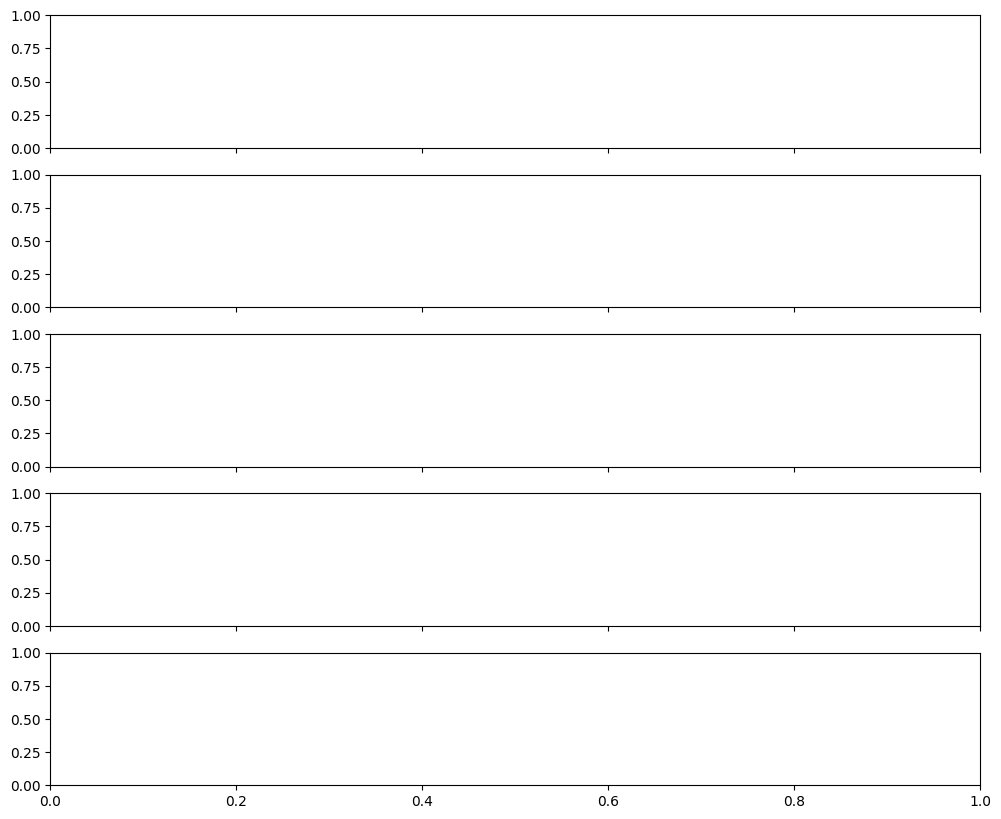

In [3]:
# Check if we should load existing bundles
bundle_info = None
if load_existing:
    try:
        logger.info("Checking for existing bundles...")
        bundle_info = load_bundle_info(bundle_dir)
        logger.info(f"Found existing bundles: {bundle_info['total_bundles']} bundles with shape " 
                    f"({bundle_info['bundle_size']}, {bundle_info['feature_dim']})")
    except (FileNotFoundError, ValueError) as e:
        logger.warning(f"Could not load existing bundles: {str(e)}")
        bundle_info = None

# If we don't have existing bundles, create them
if bundle_info is None:
    #---------------------------------------------------------------------------
    # Step 1: Load Data
    #---------------------------------------------------------------------------
    print_section_header("Step 1: Loading EEG data")
    step_start = time.time()
    
    try:
        logger.info(f"Loading data from {data_dir}")
        file_dfs, combined_df = load_eeg_data(directory_path=data_dir)
        
        n_files = len(file_dfs)
        total_rows = sum(len(df) for df in file_dfs.values())
        logger.info(f"Loaded {n_files} files with {total_rows} total rows")
        
        # Get first file for visualization
        sample_file_id = list(file_dfs.keys())[0]
        sample_df = file_dfs[sample_file_id]
        logger.info(f"Sample file {sample_file_id} shape: {sample_df.shape}")
        
        # Visualize raw data
        fig = visualize_eeg_data(sample_df, max_cols=5)
        save_plot(fig, "raw_eeg_data.png", dirs["plots"])
        
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        logger.exception("Stack trace:")
        
    
    logger.info(f"Step 1 completed in {time.time() - step_start:.2f} seconds")
    
    #---------------------------------------------------------------------------
    # Step 2: Preprocess Data and Engineer Features
    #---------------------------------------------------------------------------
    print_section_header("Step 2: Processing data and engineering features")
    step_start = time.time()
    
    try:
        # Analyze NaN patterns in the sample file first
        logger.info(f"Analyzing data quality for sample file {sample_file_id}")
        sample_quality = analyze_data_quality(sample_df)
        
        # Save the plot if it exists
        if 'plot' in sample_quality and sample_quality['plot'] is not None:
            save_plot(sample_quality['plot'], "sample_data_quality.png", dirs["plots"])

        # Save high NaN columns for later use
        high_nan_cols = sample_quality.get('high_nan_columns', [])
        logger.info(f"Saved list of {high_nan_cols} high-NaN columns for reference")
        

        processed_dfs = {}
        
        for file_id, df in file_dfs.items():
            logger.info(f"Processing file {file_id} with {len(df)} rows")
            df = df.drop(columns=["Elements"])
            # Check for NaN values in input
            nan_count_before = df.isna().sum().sum()
            if nan_count_before > 0:
                logger.warning(f"Input data for file {file_id} contains {nan_count_before} NaN values")
            

            # Clean data
            clean_df = preprocess_eeg_data(df)
            logger.info(f"Cleaned data shape: {clean_df.shape}")

            # Engineer features
            features_df = engineer_eeg_features(clean_df)
            logger.info(f"Features shape: {features_df.shape}")
            
            logger.info(f"No. of missing values after feature engineering: {features_df.isna().sum()}")
            logger.info(f"Columns after feature engineering: {features_df.columns}")
            
            # Store processed DataFrame
            processed_dfs[file_id] = features_df
            
            # If this is the first file, visualize the processed data
            if file_id == sample_file_id:
                fig = visualize_eeg_data(features_df, max_cols=5)
                save_plot(fig, "processed_eeg_data.png", dirs["plots"])
            
            # Free memory
            del clean_df
            gc.collect()


    except Exception as e:
        logger.error(f"Error in data quality analysis: {str(e)}")
        logger.exception("Stack trace:")
        # Continue with pipeline despite analysis error
    
    logger.info(f"Step 2 completed in {time.time() - step_start:.2f} seconds")

    
    #---------------------------------------------------------------------------
    # Step 3: Create Time Series Bundles on Disk
    #---------------------------------------------------------------------------
    print_section_header("Step 3: Creating time series bundles on disk")
    step_start = time.time()
    
    try:
        # Configuration for bundle creation
        bundle_config = {
            'bundle_size': bundle_size,         # Number of time steps per bundle
            'step_size': step_size,             # Step size for sliding window
            'max_files_per_batch': 2,                # Process 2 files at a time
            'max_bundles_per_file': 1000,            # Maximum 1000 bundles per file
            'chunk_size': 1000,                       # Process 500 bundles at a time
            'output_dir': bundle_dir,                # Where to save bundles
        }
        
        logger.info("Bundle creation configuration:")
        for key, value in bundle_config.items():
            logger.info(f"  {key}: {value}")
        
        # Create time series bundles and save to disk
        logger.info("Creating time series bundles with timestamp-based sampling...")
        metadata_df, bundle_info = create_coherent_time_series_bundles_disk(
            file_dfs=processed_dfs,
            **bundle_config
        )
        
        logger.info(f"Created {bundle_info['total_bundles']} bundles on disk")
        logger.info(f"Bundle size: {bundle_info['bundle_size']} time steps")
        logger.info(f"Feature dimension: {bundle_info['feature_dim']} features")
        logger.info(f"Bundles saved to: {bundle_info['output_dir']}")
        
        # Save metadata to a more readable format
        metadata_csv = os.path.join(dirs['base'], "bundle_metadata.csv")
        metadata_df.to_csv(metadata_csv, index=False)
        logger.info(f"Saved bundle metadata to {metadata_csv}")
        
        # Free memory
        del processed_dfs
        gc.collect()
        
    except Exception as e:
        logger.error(f"Error creating bundles: {str(e)}")
        logger.exception("Stack trace:")
        
    
    logger.info(f"Step 3 completed in {time.time() - step_start:.2f} seconds")
    
    #---------------------------------------------------------------------------
    # Step 4: Normalize Bundles on Disk
    #---------------------------------------------------------------------------
    print_section_header("Step 4: Normalizing bundles on disk")
    step_start = time.time()
    
    try:
        # Normalize bundles
        logger.info("Normalizing bundles...")
        bundle_info = normalize_bundles_disk(
            bundle_info=bundle_info,
            normalization='per_feature'  # Normalize each feature independently
        )
        
        logger.info(f"Normalized bundles using {bundle_info['normalization']} method")
        logger.info(f"Normalization parameters saved to {bundle_info['normalization_params_path']}")
        
    except Exception as e:
        logger.error(f"Error normalizing bundles: {str(e)}")
        logger.exception("Stack trace:")
        
    
    logger.info(f"Step 4 completed in {time.time() - step_start:.2f} seconds")

else:
    # We loaded existing bundles, so let's load the metadata too
    metadata_csv = os.path.join(dirs['base'], "bundle_metadata.csv")
    if os.path.exists(metadata_csv):
        metadata_df = pd.read_csv(metadata_csv)
        logger.info(f"Loaded existing metadata with {len(metadata_df)} rows")
    else:
        # Try to find metadata in the bundle directory
        metadata_path = os.path.join(bundle_dir, "metadata.csv")
        if os.path.exists(metadata_path):
            metadata_df = pd.read_csv(metadata_path)
            logger.info(f"Loaded metadata from bundle directory with {len(metadata_df)} rows")
        else:
            # Try joblib format
            metadata_path = os.path.join(bundle_dir, "metadata.joblib")
            if os.path.exists(metadata_path):
                metadata_df = joblib.load(metadata_path)
                logger.info(f"Loaded metadata from bundle directory with {len(metadata_df)} rows")
            else:
                logger.error("Could not find metadata file")
                


In [5]:
n_clusters = None

#---------------------------------------------------------------------------
# Step 5: Unsupervised Learning (Clustering)
#---------------------------------------------------------------------------
print_section_header("Step 5: Performing unsupervised clustering")
step_start = time.time()

try:
    # Create loader for the data
    from common import DiskBundleLoader
    
    # For clustering, we need to create a batch loader
    all_indices = np.arange(bundle_info['total_bundles'])
    
    # Split into analysis (80%) and evaluation (20%) sets
    from sklearn.model_selection import train_test_split
    analysis_indices, evaluation_indices = train_test_split(
        all_indices, test_size=0.2, random_state=42
    )
    
    logger.info(f"Split {len(all_indices)} bundles into {len(analysis_indices)} for analysis " 
                f"and {len(evaluation_indices)} for evaluation")
    
    # Save indices for future reference
    np.save(os.path.join(dirs['base'], 'analysis_indices.npy'), analysis_indices)
    np.save(os.path.join(dirs['base'], 'evaluation_indices.npy'), evaluation_indices)
    
    # Initialize the clustering model
    trainer = UnsupervisedModelTrainer(
        model_type='kmeans',
        random_state=42,
        config={'n_clusters': n_clusters if n_clusters is not None else 2}  # Default to 2 if not specified
    )
    
    # Get a sample for finding optimal number of clusters
    sample_size = min(1000, len(analysis_indices))
    sample_indices = np.random.choice(analysis_indices, sample_size, replace=False)
    
    logger.info(f"Using {sample_size} samples to determine optimal number of clusters")
    
    # Create loader for sample data
    sample_loader = DiskBundleLoader(
        bundle_info=bundle_info,
        indices=sample_indices,
        batch_size=sample_size,  # Load all in one batch
        shuffle=False,
        use_normalized=True
    )
    
    # Load sample data for cluster optimization
    sample_data = next(iter(sample_loader))
    
    # If data is 3D, flatten time dimension by taking mean
    if sample_data.ndim == 3:
        sample_data = sample_data.mean(axis=1)
        
    logger.info(f"Sample data shape for clustering: {sample_data.shape}")

    # Count number of rows that are NaN
    nan_count = np.isnan(sample_data).sum()
    logger.info(f"Number of NaN values in sample data: {nan_count}")

    # Find optimal number of clusters if not specified
    if n_clusters is None:
        optimal_n, score = trainer.find_optimal_clusters(
            sample_data, min_clusters=2, max_clusters=5
        )
        logger.info(f"Optimal number of clusters: {optimal_n} (score: {score:.4f})")
    else:
        optimal_n = n_clusters
        logger.info(f"Using specified number of clusters: {optimal_n}")
        
    # Set the optimal number of clusters in the trainer
    trainer.create_model(n_clusters=optimal_n)
    
    # Process all analysis data in batches
    logger.info(f"Clustering {len(analysis_indices)} bundles...")
    
    batch_size = 500  # Process 500 samples at a time
    analysis_batches = [analysis_indices[i:i+batch_size] for i in range(0, len(analysis_indices), batch_size)]
    
    all_labels = []
    all_data_for_vis = None  # For visualization
    
    for i, batch_indices in enumerate(analysis_batches):
        # Create loader for this batch
        batch_loader = DiskBundleLoader(
            bundle_info=bundle_info,
            indices=batch_indices,
            batch_size=len(batch_indices),
            shuffle=False,
            use_normalized=True
        )
        
        # Load batch
        batch_data = next(iter(batch_loader))
        
        # If bundles are 3D, flatten the time dimension
        if batch_data.ndim == 3:
            batch_data = batch_data.mean(axis=1)
        
        # Store first batch for visualization
        if i == 0 and all_data_for_vis is None:
            # Keep only a subset for visualization to save memory
            vis_size = min(500, len(batch_data))
            all_data_for_vis = batch_data[:vis_size].copy()
            
        # Fit or predict with the model
        if i == 0:
            # First batch - fit the model
            batch_labels = trainer.train(batch_data)
            logger.info("Fitted clustering model on first batch")
        else:
            # Subsequent batches - predict only
            batch_labels = trainer.model.predict(batch_data)
        
        all_labels.append(batch_labels)
        
        logger.info(f"  Processed batch {i+1}/{len(analysis_batches)} ({len(batch_indices)} bundles)")
        
        # Free memory
        del batch_data, batch_loader
        gc.collect()
    
    # Combine all labels
    all_labels = np.concatenate(all_labels)
    
    # Get cluster distribution
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    logger.info("Cluster distribution:")
    for label, count in zip(unique_labels, counts):
        percentage = (count / len(all_labels)) * 100
        logger.info(f"  Cluster {label}: {count} samples ({percentage:.1f}%)")
    
    # Visualize clusters using stored data subset
    if all_data_for_vis is not None:
        # Reduce dimensions for visualization
        # Try t-SNE first, fall back to PCA if not available
        try:
            from sklearn.manifold import TSNE
            logger.info("Using t-SNE for dimension reduction...")
            X_reduced = TSNE(n_components=2, random_state=42).fit_transform(all_data_for_vis)
        except:
            logger.info("Falling back to PCA for dimension reduction...")
            from sklearn.decomposition import PCA
            X_reduced = PCA(n_components=2, random_state=42).fit_transform(all_data_for_vis)
        
        # Get corresponding labels
        vis_labels = trainer.model.predict(all_data_for_vis)
        
        # Create scatter plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=vis_labels, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'EEG Data Clusters (n={optimal_n})')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.tight_layout()
        save_plot(plt.gcf(), "cluster_visualization.png", dirs["plots"])
        
        # Free memory
        del all_data_for_vis
        gc.collect()
    
    # Save the model
    model_path = os.path.join(dirs["models"], "unsupervised_model.joblib")
    trainer.save_model(model_path)
    logger.info(f"Saved clustering model to {model_path}")
    
    # Add cluster labels to metadata
    metadata_with_clusters = metadata_df.copy()
    metadata_with_clusters['cluster'] = -1  # Initialize with -1 (unclustered)
    
    # Map indices to bundle_idx in metadata
    for i, idx in enumerate(analysis_indices):
        if i < len(all_labels):
            metadata_with_clusters.loc[metadata_with_clusters['bundle_idx'] == idx, 'cluster'] = all_labels[i]
    
    # Save updated metadata
    metadata_path = os.path.join(dirs["base"], "metadata_with_clusters.csv")
    metadata_with_clusters.to_csv(metadata_path, index=False)
    logger.info(f"Saved metadata with cluster labels to {metadata_path}")
    
except Exception as e:
    logger.error(f"Error in unsupervised learning: {str(e)}")
    logger.exception("Stack trace:")

logger.info(f"Step 5 completed in {time.time() - step_start:.2f} seconds")


2025-03-14 09:32:56,308 - eeg_classification - INFO - 
2025-03-14 09:32:56,308 - eeg_classification - INFO - 


2025-03-14 09:32:56,308 - eeg_classification - INFO - 


2025-03-14 09:32:56,311 - eeg_classification - INFO -  Step 5: Performing unsupervised clustering
2025-03-14 09:32:56,311 - eeg_classification - INFO -  Step 5: Performing unsupervised clustering


2025-03-14 09:32:56,311 - eeg_classification - INFO -  Step 5: Performing unsupervised clustering


2025-03-14 09:32:56,313 - eeg_classification - INFO - ================================================================================
2025-03-14 09:32:56,313 - eeg_classification - INFO - ================================================================================


2025-03-14 09:32:56,313 - eeg_classification - INFO - ================================================================================


2025-03-14 09:32:56,318 - eeg_classification - INFO - Split 9059 bundles into 7247 for analysis and 1812 for evaluation
2025-03-14 09:32:56,318 - eeg_classification - INFO - Split 9059 bundles into 7247 for analysis and 1812 for evaluation


2025-03-14 09:32:56,318 - eeg_classification - INFO - Split 9059 bundles into 7247 for analysis and 1812 for evaluation


2025-03-14 09:32:56,321 - eeg_classification - INFO - Initialized UnsupervisedModelTrainer with model_type=kmeans
2025-03-14 09:32:56,321 - eeg_classification - INFO - Initialized UnsupervisedModelTrainer with model_type=kmeans


2025-03-14 09:32:56,321 - eeg_classification - INFO - Initialized UnsupervisedModelTrainer with model_type=kmeans


2025-03-14 09:32:56,323 - eeg_classification - INFO - Using 1000 samples to determine optimal number of clusters
2025-03-14 09:32:56,323 - eeg_classification - INFO - Using 1000 samples to determine optimal number of clusters


2025-03-14 09:32:56,323 - eeg_classification - INFO - Using 1000 samples to determine optimal number of clusters


2025-03-14 09:33:04,226 - eeg_classification - INFO - Sample data shape for clustering: (1000, 138)
2025-03-14 09:33:04,226 - eeg_classification - INFO - Sample data shape for clustering: (1000, 138)


2025-03-14 09:33:04,226 - eeg_classification - INFO - Sample data shape for clustering: (1000, 138)


2025-03-14 09:33:04,230 - eeg_classification - INFO - Number of NaN values in sample data: 10000
2025-03-14 09:33:04,230 - eeg_classification - INFO - Number of NaN values in sample data: 10000


2025-03-14 09:33:04,230 - eeg_classification - INFO - Number of NaN values in sample data: 10000


2025-03-14 09:33:04,232 - eeg_classification - INFO - Finding optimal number of clusters between 2 and 5
2025-03-14 09:33:04,232 - eeg_classification - INFO - Finding optimal number of clusters between 2 and 5


2025-03-14 09:33:04,232 - eeg_classification - INFO - Finding optimal number of clusters between 2 and 5


2025-03-14 09:33:04,235 - eeg_classification - ERROR - Error finding optimal clusters: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
2025-03-14 09:33:04,235 - eeg_classification - ERROR - Error finding optimal clusters: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regresso

2025-03-14 09:33:04,235 - eeg_classification - ERROR - Error finding optimal clusters: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


2025-03-14 09:33:04,245 - eeg_classification - ERROR - Error in unsupervised learning: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
2025-03-14 09:33:04,245 - eeg_classification - ERROR - Error in unsupervised learning: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regresso

2025-03-14 09:33:04,245 - eeg_classification - ERROR - Error in unsupervised learning: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


2025-03-14 09:33:04,248 - eeg_classification - ERROR - Stack trace:
Traceback (most recent call last):
  File "C:\Users\Huai\AppData\Local\Temp\ipykernel_32816\847493052.py", line 66, in <module>
    optimal_n, score = trainer.find_optimal_clusters(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\unsupervised.py", line 192, in find_optimal_clusters
    labels = kmeans.fit_predict(X)
             ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\miniconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py", line 1064, in fit_predict
    return self.fit(X, sample_weight=sample_weight).labels_
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\miniconda3\envs\eeg\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\miniconda3\envs\eeg\Lib\site-packages\sklearn\clus

2025-03-14 09:33:04,248 - eeg_classification - ERROR - Stack trace:
Traceback (most recent call last):
  File "C:\Users\Huai\AppData\Local\Temp\ipykernel_32816\847493052.py", line 66, in <module>
    optimal_n, score = trainer.find_optimal_clusters(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\Documents\GitHub\EEG-classification\training\common\unsupervised.py", line 192, in find_optimal_clusters
    labels = kmeans.fit_predict(X)
             ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\miniconda3\envs\eeg\Lib\site-packages\sklearn\cluster\_kmeans.py", line 1064, in fit_predict
    return self.fit(X, sample_weight=sample_weight).labels_
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\miniconda3\envs\eeg\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Huai\miniconda3\envs\eeg\Lib\site-packages\sklearn\clus

2025-03-14 09:33:04,251 - eeg_classification - INFO - Step 5 completed in 7.94 seconds
2025-03-14 09:33:04,251 - eeg_classification - INFO - Step 5 completed in 7.94 seconds


2025-03-14 09:33:04,251 - eeg_classification - INFO - Step 5 completed in 7.94 seconds


In [ ]:

#---------------------------------------------------------------------------
# Step 6: Cluster Evaluation
#---------------------------------------------------------------------------
print_section_header("Step 6: Evaluating clustering results")
step_start = time.time()

try:
    # Evaluate on the held-out evaluation set
    logger.info(f"Evaluating clustering on {len(evaluation_indices)} held-out bundles")
    
    # Process in batches
    batch_size = 500
    evaluation_batches = [evaluation_indices[i:i+batch_size] for i in range(0, len(evaluation_indices), batch_size)]
    
    eval_labels = []
    
    for i, batch_indices in enumerate(evaluation_batches):
        # Create loader for this batch
        batch_loader = DiskBundleLoader(
            bundle_info=bundle_info,
            indices=batch_indices,
            batch_size=len(batch_indices),
            shuffle=False,
            use_normalized=True
        )
        
        # Load batch
        batch_data = next(iter(batch_loader))
        
        # If bundles are 3D, flatten the time dimension
        if batch_data.ndim == 3:
            batch_data = batch_data.mean(axis=1)
            
        # Predict clusters
        batch_labels = trainer.model.predict(batch_data)
        eval_labels.append(batch_labels)
        
        logger.info(f"  Processed evaluation batch {i+1}/{len(evaluation_batches)} ({len(batch_indices)} bundles)")
        
        # Free memory
        del batch_data, batch_loader
        gc.collect()
    
    # Combine all evaluation labels
    eval_labels = np.concatenate(eval_labels)
    
    # Get cluster distribution
    eval_unique_labels, eval_counts = np.unique(eval_labels, return_counts=True)
    logger.info("Cluster distribution in evaluation data:")
    for label, count in zip(eval_unique_labels, eval_counts):
        percentage = (count / len(eval_labels)) * 100
        logger.info(f"  Cluster {label}: {count} samples ({percentage:.1f}%)")
    
    # Compare distributions between analysis and evaluation sets
    logger.info("Comparing cluster distributions:")
    logger.info("  Cluster  |  Analysis  |  Evaluation")
    logger.info("  --------|------------|------------")
    for label in range(optimal_n):
        # Find index of this label in the analysis set
        analysis_idx = np.where(unique_labels == label)[0]
        analysis_count = counts[analysis_idx[0]] if len(analysis_idx) > 0 else 0
        analysis_pct = (analysis_count / len(all_labels)) * 100 if len(all_labels) > 0 else 0
        
        # Find index of this label in the evaluation set
        eval_idx = np.where(eval_unique_labels == label)[0]
        eval_count = eval_counts[eval_idx[0]] if len(eval_idx) > 0 else 0
        eval_pct = (eval_count / len(eval_labels)) * 100 if len(eval_labels) > 0 else 0
        
        logger.info(f"  {label}       |  {analysis_pct:.1f}%     |  {eval_pct:.1f}%")
    
    # Calculate silhouette scores if possible
    try:
        from sklearn.metrics import silhouette_score
        
        # We need a sample of data for silhouette calculation
        # This might be memory intensive for large datasets
        sample_size = min(10000, len(evaluation_indices))
        sample_indices = np.random.choice(evaluation_indices, sample_size, replace=False)
        
        # Load the sample
        sample_loader = DiskBundleLoader(
            bundle_info=bundle_info,
            indices=sample_indices,
            batch_size=sample_size,
            shuffle=False,
            use_normalized=True
        )
        
        # Get the data
        sample_data = next(iter(sample_loader))
        
        # If 3D, flatten
        if sample_data.ndim == 3:
            sample_data = sample_data.mean(axis=1)
        
        # Predict labels
        sample_labels = trainer.model.predict(sample_data)
        
        # Calculate silhouette score
        sil_score = silhouette_score(sample_data, sample_labels)
        logger.info(f"Silhouette Score on evaluation data: {sil_score:.4f}")
        
        # Add to summary dict
        eval_scores = {"silhouette_score": sil_score}
        
        # Free memory
        del sample_data, sample_loader
        gc.collect()
        
    except Exception as e:
        logger.warning(f"Could not calculate silhouette score: {str(e)}")
        eval_scores = {}
    
    # Calculate cluster evaluation metrics
    metrics = trainer.evaluate(sample_data, sample_labels)
    logger.info("Cluster evaluation metrics:")
    for metric, value in metrics.items():
        logger.info(f"  {metric}: {value:.4f}")
        eval_scores[metric] = value
    
    # Save evaluation metrics
    eval_path = os.path.join(dirs["base"], "clustering_evaluation.joblib")
    joblib.dump(eval_scores, eval_path)
    logger.info(f"Saved evaluation metrics to {eval_path}")
    
except Exception as e:
    logger.error(f"Error in cluster evaluation: {str(e)}")
    logger.exception("Stack trace:")

logger.info(f"Step 6 completed in {time.time() - step_start:.2f} seconds")

#---------------------------------------------------------------------------
# Pipeline Summary
#---------------------------------------------------------------------------
total_time = time.time() - start_time

print_section_header("EEG PROCESSING PIPELINE COMPLETE")
logger.info(f"Total execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
logger.info(f"Results saved to {output_dir}")
logger.info("\nSummary:")
logger.info(f"  - Bundles created/loaded: {bundle_info['total_bundles']}")
logger.info(f"  - Number of clusters: {optimal_n}")

if eval_scores:
    logger.info("  - Evaluation scores:")
    for metric, value in eval_scores.items():
        logger.info(f"    * {metric}: {value:.4f}")

logger.info("\nOutput Files:")
logger.info(f"  - Bundle info: {os.path.join(bundle_dir, 'bundle_info.joblib')}")
logger.info(f"  - Metadata: {os.path.join(dirs['base'], 'metadata_with_clusters.csv')}")
logger.info(f"  - Trained model: {os.path.join(dirs['models'], 'unsupervised_model.joblib')}")
logger.info(f"  - Visualizations: {dirs['plots']}")
logger.info(f"  - Log file: {log_file}")

logger.info("\nNext steps:")
logger.info("  1. Review the cluster visualizations to understand the patterns")
logger.info("  2. Analyze clusters in relation to EEG channel characteristics")
logger.info("  3. Use clusters for supervised learning or further analysis")